# **Rock Scissors Paper CNN Model Comparison**

## **File Imports**

The following libraries are used:

- `os`, `shutil`: File and directory operations
- `PIL`: Image loading and manipulation
- `numpy`: Numerical computations
- `matplotlib`, `seaborn`: Data visualization
- `time`, `random`: Timing and randomness
- `tensorflow`, `keras`: Neural network creation and training
- `keras.applications.vgg16`, `keras.applications.resnet50`: Pre-trained CNNs and preprocessing
- `keras.optimizers`: Optimizer setup (e.g. Adam)
- `keras.models.load_model`: Loading saved models


In [72]:
# Import necessary libraries
import tensorflow as tf
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications import ResNet50
from keras.optimizers import Adam
from keras.models import load_model
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import random
import shutil
import seaborn as sns

## **Environment and Data Preperation**

### **Environment Setup and Configuration**

- The student ID is used as a fixed random seed for reproducibility  

- TensorFlow and NumPy random seeds are initialised  

- Image size parameters are defined for different model types  

- Batch size and number of classes are set  

- Dataset path is assigned 

- The environment setup is confirmed with version and seed output  


In [73]:
# Set my Sudent ID as random seed
STUDENT_ID = 409920 

# Set random seeds for reproducibility
tf.random.set_seed(STUDENT_ID)
np.random.seed(STUDENT_ID)

# Dataset parameters
IMG_SIZE_SMALL = 128  # Size for basic CNNs (Baseline, Deep Reg, Grayscale)
IMG_SIZE_VGG = 224    # Size for VGG16
IMG_SIZE_SQUEEZE = 227  # Size for SqueezeNet
BATCH_SIZE = 32

# Define paths
dataset_path = 'dataset'

# Number of classes in the dataset
NUM_CLASSES = 3  # rock, paper, scissors

print("TensorFlow version:", tf.__version__)
print("Setup complete with student ID", STUDENT_ID, "as random seed")

TensorFlow version: 2.19.0
Setup complete with student ID 409920 as random seed


### **Dataset Summary and Visualisation**

- Image counts are computed for each class (`rock`, `paper`, `scissors`) across `train`, `validation`, and `test` splits  

- Total image counts and proportions per split are printed  

- Bar plots show class distribution per split  

- A pie chart visualises the proportion of images in each dataset split  

- Class balance is calculated and printed for each split individually  


Total images in dataset: 2925

Split        Paper      Rock       Scissors   Total       
------------------------------------------------------------
train        683        683        683        2049         (70.1%)
validation   97         97         97         291          (9.9%)
test         195        195        195        585          (20.0%)


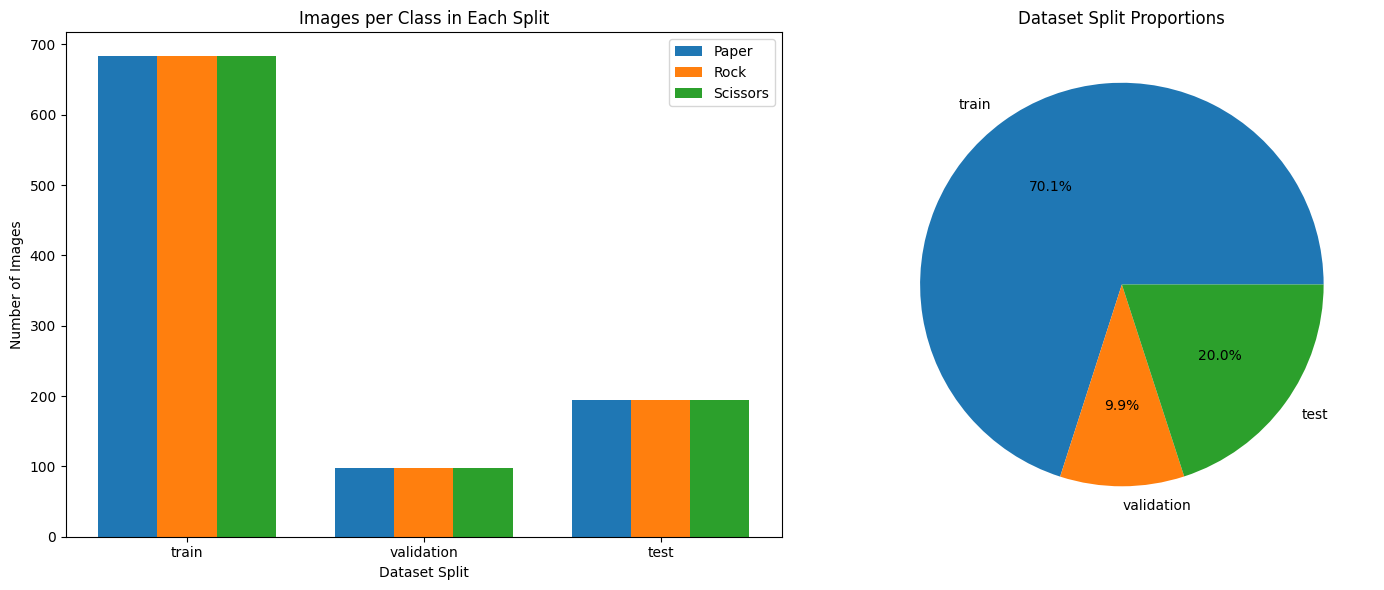


CLASS BALANCE WITHIN EACH SPLIT:
------------------------------------------------------------
TRAIN:
  Paper:    683 images (33.3%)
  Rock:     683 images (33.3%)
  Scissors: 683 images (33.3%)

VALIDATION:
  Paper:    97 images (33.3%)
  Rock:     97 images (33.3%)
  Scissors: 97 images (33.3%)

TEST:
  Paper:    195 images (33.3%)
  Rock:     195 images (33.3%)
  Scissors: 195 images (33.3%)



In [74]:
# Function to count images in a directory and its subdirectories
def count_images_in_directory(directory):
    class_counts = {}
    total_count = 0
    
    # Check if directory exists
    if not os.path.exists(directory):
        print(f"Directory {directory} does not exist!")
        return class_counts, total_count
    
    # Get all subdirectories (classes)
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    
    # If there are no subdirectories, count images directly in the directory
    if not class_dirs:
        image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        return {"no_class": len(image_files)}, len(image_files)
    
    # Count images in each class
    for class_name in class_dirs:
        class_path = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        count = len(image_files)
        class_counts[class_name] = count
        total_count += count
    
    return class_counts, total_count

# Get counts for each split
dataset_root = 'dataset'
splits = ['train', 'validation', 'test']
all_counts = {}
total_images = 0

for split in splits:
    split_path = os.path.join(dataset_root, split)
    class_counts, split_total = count_images_in_directory(split_path)
    all_counts[split] = {
        'class_counts': class_counts,
        'total': split_total
    }
    total_images += split_total

# Print results in a formatted way
print(f"Total images in dataset: {total_images}\n")
print("{:<12} {:<10} {:<10} {:<10} {:<12}".format("Split", "Paper", "Rock", "Scissors", "Total"))
print("-" * 60)

for split in splits:
    counts = all_counts[split]['class_counts']
    split_total = all_counts[split]['total']
    
    # Get counts for each class (or 0 if class not present)
    paper_count = counts.get('paper', 0)
    rock_count = counts.get('rock', 0)
    scissors_count = counts.get('scissors', 0)
    
    # Calculate percentages of total dataset
    split_percent = (split_total / total_images) * 100
    
    print("{:<12} {:<10} {:<10} {:<10} {:<12} ({:.1f}%)".format(
        split, paper_count, rock_count, scissors_count, split_total, split_percent
    ))

# Create visualisations
plt.figure(figsize=(15, 6))

# Plot 1: Images per class in each split
plt.subplot(1, 2, 1)
width = 0.25
x = np.arange(len(splits))

# Extract counts for plotting
paper_counts = [all_counts[split]['class_counts'].get('paper', 0) for split in splits]
rock_counts = [all_counts[split]['class_counts'].get('rock', 0) for split in splits]
scissors_counts = [all_counts[split]['class_counts'].get('scissors', 0) for split in splits]

plt.bar(x - width, paper_counts, width, label='Paper')
plt.bar(x, rock_counts, width, label='Rock')
plt.bar(x + width, scissors_counts, width, label='Scissors')

plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.title('Images per Class in Each Split')
plt.xticks(x, splits)
plt.legend()

# Plot 2: Split proportions
plt.subplot(1, 2, 2)
split_totals = [all_counts[split]['total'] for split in splits]
plt.pie(split_totals, labels=splits, autopct='%1.1f%%')
plt.title('Dataset Split Proportions')

plt.tight_layout()
plt.show()

print("\nCLASS BALANCE WITHIN EACH SPLIT:")
print("-" * 60)
for split in splits:
    counts = all_counts[split]['class_counts']
    split_total = all_counts[split]['total']
    
    # Get counts for each class (or 0 if class not present)
    paper_count = counts.get('paper', 0)
    rock_count = counts.get('rock', 0)
    scissors_count = counts.get('scissors', 0)
    
    # Calculate percentages within the split
    paper_percent = (paper_count / split_total) * 100 if split_total > 0 else 0
    rock_percent = (rock_count / split_total) * 100 if split_total > 0 else 0
    scissors_percent = (scissors_count / split_total) * 100 if split_total > 0 else 0
    
    print(f"{split.upper()}:")
    print(f"  Paper:    {paper_count} images ({paper_percent:.1f}%)")
    print(f"  Rock:     {rock_count} images ({rock_percent:.1f}%)")
    print(f"  Scissors: {scissors_count} images ({scissors_percent:.1f}%)")
    print()

### **Dataset Rebalancing**

Here:

- A flag determines whether to rebalance the dataset or not 

- Class distributions are counted for each split (`train`, `validation`, `test`)  

- If enabled, a 70/10/20 split is approximated by moving images from `train` to the other splits  

- The number of images to move per class is calculated and applied  

- Updated class and split distributions are printed  

- If disabled, the current dataset distribution is displayed without making changes  


In [75]:
# Set to False to prevent rebalancing
PERFORM_REBALANCING = False

# Set random seed for reproducibility
random.seed(STUDENT_ID)

def rebalance_dataset(dataset_path, source_split='train', target_splits=None, 
                      classes=['paper', 'rock', 'scissors']):
    """
    Rebalance the dataset by moving images from source_split to target_splits.
    
    Args:
        dataset_path: Path to the dataset root folder
        source_split: Folder to take images from (e.g., 'train')
        target_splits: Dictionary mapping target split names to images per class to move
        classes: List of class folders
    """
    if target_splits is None:
        return
    
    for class_name in classes:
        # Define source directory
        source_dir = os.path.join(dataset_path, source_split, class_name)
        
        # Get all image files in source directory
        image_files = [f for f in os.listdir(source_dir) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Keep track of which images have been moved
        moved_images = []
        
        # Process each target split
        for target_split, images_per_class in target_splits.items():
            # Define target directory
            target_dir = os.path.join(dataset_path, target_split, class_name)
            
            # Create target directory if it doesn't exist
            os.makedirs(target_dir, exist_ok=True)
            
            # Get remaining images that haven't been moved yet
            remaining_images = [img for img in image_files if img not in moved_images]
            
            # Check if we have enough images to move
            if len(remaining_images) < images_per_class:
                print(f"Warning: Not enough images in {source_dir}. Found {len(remaining_images)}, need {images_per_class}")
                continue
                
            # Randomly select images to move
            images_to_move = random.sample(remaining_images, images_per_class)
            moved_images.extend(images_to_move)
            
            # Move selected images to target directory
            for image in images_to_move:
                source_file = os.path.join(source_dir, image)
                target_file = os.path.join(target_dir, image)
                shutil.move(source_file, target_file)
                print(f"Moved: {image} from {source_split}/{class_name} to {target_split}/{class_name}")
        
        total_moved = len(moved_images)
        print(f"Moved a total of {total_moved} images from {source_split}/{class_name}")

# Calculate proper amounts to move to achieve approximately 70/10/20 split
def calculate_moves_for_target_split(total_images=2925, current_splits=None):
    """
    Calculate how many images to move from train to validation and test
    to achieve approximately 70/10/20 split.
    """
    if current_splits is None:
        # Use your current distribution
        current_splits = {
            'train': 2520,
            'validation': 33,
            'test': 372
        }
    
    # Target numbers (based on 70/10/20 of total)
    target_train = int(total_images * 0.7)
    target_validation = int(total_images * 0.1)
    target_test = int(total_images * 0.2)
    
    # Calculate how many images to move from train
    to_validation = target_validation - current_splits['validation']
    to_test = target_test - current_splits['test']
    
    # Calculate per class (assuming 3 classes)
    to_validation_per_class = to_validation // 3
    to_test_per_class = to_test // 3
    
    print(f"To achieve 70/10/20 split:")
    print(f"  Move {to_validation_per_class} images per class from train to validation")
    print(f"  Move {to_test_per_class} images per class from train to test")
    
    return {
        'validation': to_validation_per_class,
        'test': to_test_per_class
    }

# Verify the distribution
def count_images(directory):
    """Count the number of images in each class directory."""
    class_counts = {}
    
    # Check if directory exists
    if not os.path.exists(directory):
        return class_counts
    
    # Get all subdirectories (classes)
    class_dirs = [d for d in os.listdir(directory) 
                  if os.path.isdir(os.path.join(directory, d))]
    
    # Count images in each class
    for class_name in class_dirs:
        class_path = os.path.join(directory, class_name)
        image_files = [f for f in os.listdir(class_path) 
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)
    
    return class_counts

# Count current distribution
dataset_path = 'dataset'

if PERFORM_REBALANCING:
    # This block contains the actual rebalancing code
    current_distribution = {}
    total_images = 0

    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(dataset_path, split)
        counts = count_images(split_path)
        split_total = sum(counts.values())
        current_distribution[split] = split_total
        total_images += split_total

    print("\nCURRENT DATASET DISTRIBUTION:")
    for split, count in current_distribution.items():
        print(f"  {split.capitalize()}: {count} images ({count/total_images*100:.1f}%)")

    # Calculate how many images to move
    moves = calculate_moves_for_target_split(total_images, current_distribution)

    # Run the rebalancing
    print("\nRebalancing dataset...")
    rebalance_dataset(dataset_path, 'train', moves)

    # Display the new counts
    print("\nNEW DATASET DISTRIBUTION:")
    new_distribution = {}
    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(dataset_path, split)
        counts = count_images(split_path)
        split_total = sum(counts.values())
        new_distribution[split] = split_total
        print(f"  {split.capitalize()} SET:")
        for class_name, count in counts.items():
            print(f"    {class_name}: {count} images")
        print(f"    Total: {split_total} images ({split_total/total_images*100:.1f}%)")

    print("\nRebalancing complete!")
else:
    # This block just shows information about the previous rebalancing
    print("REBALANCING SKIPPED - Dataset was previously rebalanced")
    print("To run rebalancing again, set PERFORM_REBALANCING = True (not recommended)")
    
    # Instead of rebalancing, just display the current distribution
    current_distribution = {}
    total_images = 0

    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(dataset_path, split)
        counts = count_images(split_path)
        split_total = sum(counts.values())
        current_distribution[split] = split_total
        total_images += split_total

    print("\nCURRENT DATASET DISTRIBUTION:")
    for split, count in current_distribution.items():
        print(f"  {split.capitalize()}: {count} images ({count/total_images*100:.1f}%)")
    
    print("\nClass distribution within each split:")
    for split in ['train', 'validation', 'test']:
        split_path = os.path.join(dataset_path, split)
        counts = count_images(split_path)
        print(f"  {split.capitalize()} SET:")
        for class_name, count in sorted(counts.items()):
            print(f"    {class_name}: {count} images")

REBALANCING SKIPPED - Dataset was previously rebalanced
To run rebalancing again, set PERFORM_REBALANCING = True (not recommended)

CURRENT DATASET DISTRIBUTION:
  Train: 2049 images (70.1%)
  Validation: 291 images (9.9%)
  Test: 585 images (20.0%)

Class distribution within each split:
  Train SET:
    paper: 683 images
    rock: 683 images
    scissors: 683 images
  Validation SET:
    paper: 97 images
    rock: 97 images
    scissors: 97 images
  Test SET:
    paper: 195 images
    rock: 195 images
    scissors: 195 images


## **Dataset Preperation and Loading**

### **Step 1: Loading and Preprocessing the Dataset**

In this step:

- Datasets are loaded from directory structures using TensorFlow utilities

- Images are resized to a target resolution and optionally converted to grayscale 

- Pixel values are normalised to a 0–1 range  

- Optional data augmentation is applied during training (random flip, rotation, zoom) 

- Prefetching is used to optimize the input pipeline for performance  

- Class names are extracted for use in evaluation and visualisation  


In [76]:
# Function to load and preprocess datasets
def load_dataset(split_path, img_size, grayscale=False, batch_size=BATCH_SIZE, augment=False):
    """
    Load and prepare a dataset with given parameters.
    
    Args:
        split_path: Path to dataset split folder (train, validation, or test)
        img_size: Target image size (height and width)
        grayscale: If True, convert images to grayscale
        batch_size: Number of images per batch
        augment: If True, apply data augmentation (for training only)
        
    Returns:
        Preprocessed TensorFlow dataset
    """
    # Load dataset from directory structure
    dataset = tf.keras.utils.image_dataset_from_directory(
        split_path,
        image_size=(img_size, img_size),
        batch_size=batch_size,
        seed=STUDENT_ID  # Using student ID as seed for reproducibility
    )
    
    # Store class names before applying transformations
    class_names = dataset.class_names
    
    # Define preprocessing operations
    preprocessing_layers = []
    
    # Normalization layer (scale pixel values to 0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    
    # Convert to grayscale if specified
    if grayscale:
        dataset = dataset.map(
            lambda x, y: (tf.image.rgb_to_grayscale(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Apply normalization
    dataset = dataset.map(
        lambda x, y: (normalization_layer(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Apply data augmentation if specified (only for training)
    if augment:
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1)
        ])
        
        dataset = dataset.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    
    # Optimize pipeline with prefetching
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset, class_names

### **Step 2: Visualising Sample Images**

In this step:

- A batch of sample images is taken from the dataset  

- Images are displayed in a grid format (3×3 by default)  

- Titles indicate their corresponding class labels 

- Grayscale or color display is handled based on the input flag  

- The visualisation helps confirm preprocessing and class alignment  


In [77]:
# Function to visualise sample images from a dataset
def visualise_dataset_samples(dataset, class_names, title, grayscale=False, samples=9):
    """
    Visualise sample images from a dataset
    
    Args:
        dataset: TensorFlow dataset to visualise
        class_names: List of class names
        title: Plot title
        grayscale: If True, visualise as grayscale images
        samples: Number of samples to visualise
    """
    plt.figure(figsize=(10, 10))
    plt.suptitle(title, fontsize=16)
    
    # Get a batch of images from the dataset
    for images, labels in dataset.take(1):
        # Plot each image
        for i in range(min(samples, len(images))):
            plt.subplot(3, 3, i + 1)
            
            # Display image based on color mode
            if grayscale:
                plt.imshow(images[i, :, :, 0], cmap='gray')
            else:
                # Remove the uint8 conversion - directly display the normalised float values
                plt.imshow(images[i].numpy())
                
            plt.title(class_names[labels[i]])
            plt.axis("off")
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

### **Step 3: Loading and Verifying RGB Datasets (128×128)**

In this step:

- The training, validation, and test datasets are loaded at 128×128 resolution in RGB mode 

- Data augmentation is applied only to the training set  

- Dataset structure is verified by inspecting shapes, data types, and label samples  

- The number of batches and estimated total images per split are printed  

- Sample training images and augmented versions are visualised to confirm preprocessing  


Loading RGB datasets (128x128)...
Found 2049 files belonging to 3 classes.
Found 291 files belonging to 3 classes.
Found 585 files belonging to 3 classes.
Classes detected: ['paper', 'rock', 'scissors']
Image batch shape: (32, 128, 128, 3)
Label batch shape: (32,)
Image data type: <dtype: 'float32'>
Min pixel value: 0.036122169345617294
Max pixel value: 1.0
First few labels: [1 1 2 2 1]
Training dataset: 65 batches
Validation dataset: 10 batches
Test dataset: 19 batches
Approximate number of images:
  Training: ~2080 images
  Validation: ~320 images
  Test: ~608 images


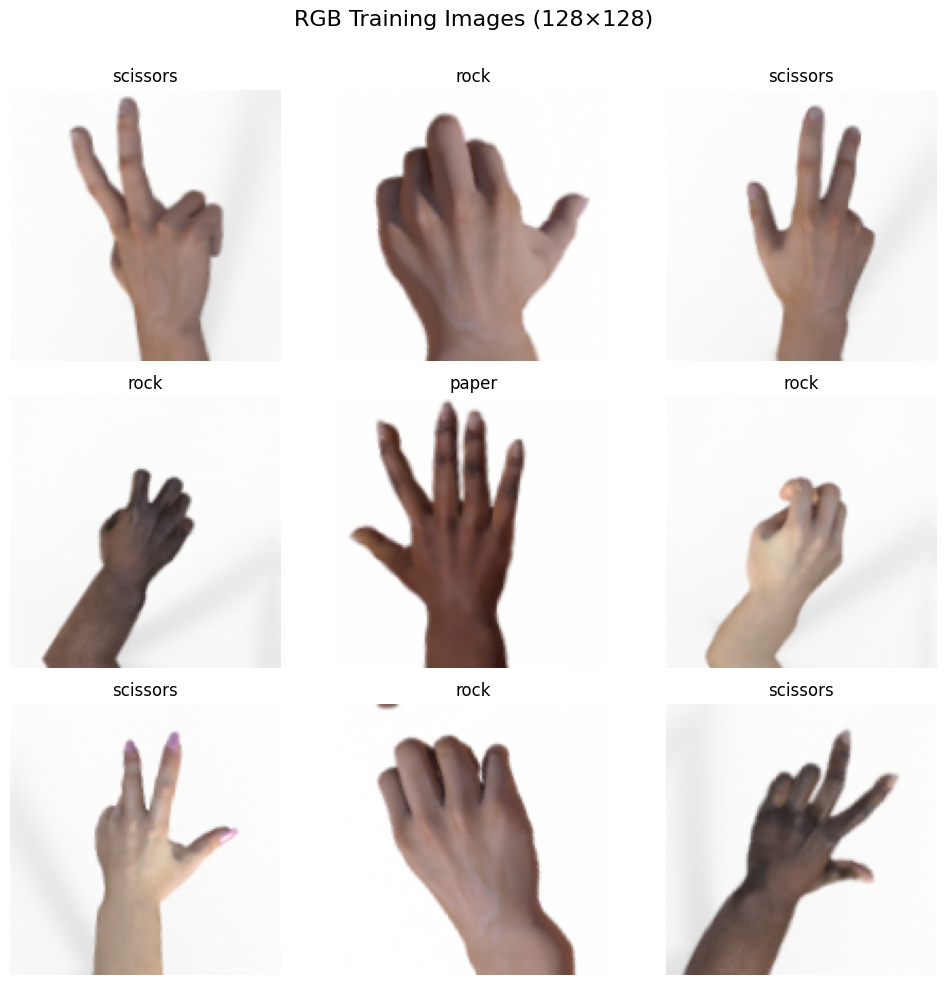

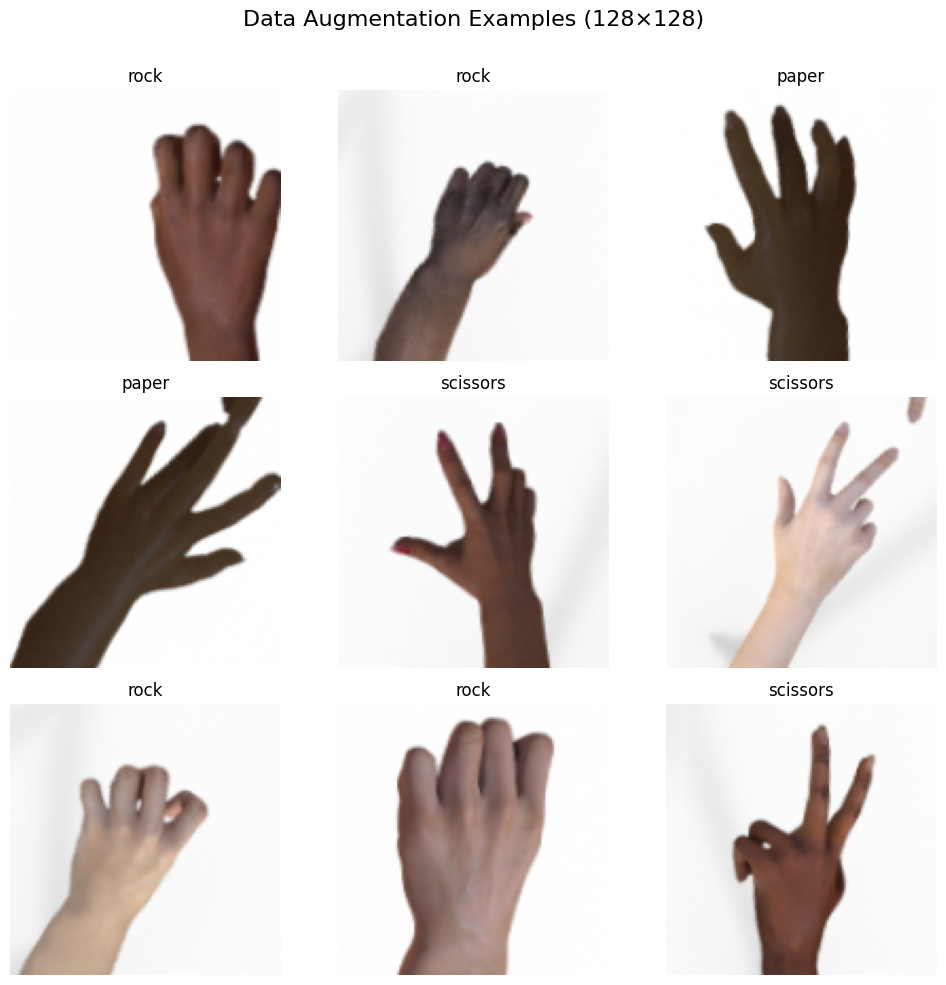

RGB dataset loading verified successfully!


In [78]:
# Load RGB datasets for Baseline and Deep Regularized CNN (128x128)
print("Loading RGB datasets (128x128)...")

# Training set with augmentation 
train_ds_small_rgb, train_class_names = load_dataset(
    os.path.join(dataset_path, 'train'), 
    IMG_SIZE_SMALL, 
    grayscale=False, 
    augment=True
)

# Validation set (no augmentation)
val_ds_small_rgb, _ = load_dataset(
    os.path.join(dataset_path, 'validation'), 
    IMG_SIZE_SMALL, 
    grayscale=False
)

# Test set (no augmentation)
test_ds_small_rgb, _ = load_dataset(
    os.path.join(dataset_path, 'test'), 
    IMG_SIZE_SMALL, 
    grayscale=False
)

# Get class names from the dataset
class_names = train_class_names
print(f"Classes detected: {class_names}")

# Get the shape of the images and labels in the dataset
for images, labels in train_ds_small_rgb.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    print(f"Image data type: {images.dtype}")
    print(f"Min pixel value: {tf.reduce_min(images).numpy()}")
    print(f"Max pixel value: {tf.reduce_max(images).numpy()}")
    print(f"First few labels: {labels[:5].numpy()}")

# Count number of batches in each dataset
print(f"Training dataset: {len(list(train_ds_small_rgb))} batches")
print(f"Validation dataset: {len(list(val_ds_small_rgb))} batches")
print(f"Test dataset: {len(list(test_ds_small_rgb))} batches")

# Estimate total number of images
train_images = len(list(train_ds_small_rgb)) * BATCH_SIZE
val_images = len(list(val_ds_small_rgb)) * BATCH_SIZE
test_images = len(list(test_ds_small_rgb)) * BATCH_SIZE
print(f"Approximate number of images:")
print(f"  Training: ~{train_images} images")
print(f"  Validation: ~{val_images} images")
print(f"  Test: ~{test_images} images")

# Visualise sample training images
visualise_dataset_samples(
    train_ds_small_rgb, 
    class_names, 
    title="RGB Training Images (128×128)"
)

# Visualise sample augmented images
# Run this cell multiple times to see different augmentations
plt.figure(figsize=(10, 10))
plt.suptitle("Data Augmentation Examples (128×128)", fontsize=16)

for images, labels in train_ds_small_rgb.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        # Use the same display approach as in the visualise_dataset_samples function
        # Don't convert to uint8, display the normalised float values directly
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

print("RGB dataset loading verified successfully!")

## **Baseline CNN**

### **Step 1: Defining the Baseline CNN Model**

- A simple Convolutional Neural Network is defined using `Sequential` API  

- The model includes 3 convolutional blocks followed by max pooling  

- A dense layer and dropout are added for classification and regularization 

- The final layer uses softmax activation for multiclass classification 

- The model is compiled with the Adam optimizer and sparse categorical crossentropy loss  


In [79]:
# Define the Baseline CNN model
def create_baseline_cnn(input_shape=(IMG_SIZE_SMALL, IMG_SIZE_SMALL, 3), num_classes=3):
    """
    Create a simple baseline CNN model with 3 convolutional layers
    
    Args:
        input_shape: Shape of input images
        num_classes: Number of output classes
        
    Returns:
        Compiled model
    """
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten and Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Dropout for regularization
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


### **Step 2: Training and Evaluating the Model**

In this step:

- The model is trained using early stopping and model checkpointing callbacks 

- The best model is saved in `.keras` format based on validation accuracy  

- Training time is measured in seconds  

- Inference time is calculated in milliseconds per image using the validation set  

- Final validation accuracy and loss are reported  

- All metrics and the training history are returned for later comparison  


In [80]:
# Update the train_and_evaluate_model function to use .keras format
def train_and_evaluate_model(model, train_ds, val_ds, model_name, epochs=15):
    """
    Train and evaluate a model, measuring training time and inference speed
    
    Args:
        model: The model to train
        train_ds: Training dataset
        val_ds: Validation dataset
        model_name: Name for saving the model
        epochs: Number of training epochs
        
    Returns:
        Dictionary with training results and metrics
    """
    print(f"\n===== Training {model_name} =====")
    
    # Callbacks for training
    callbacks = [
        # Early stopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', 
            patience=5,
            restore_best_weights=True
        ),
        # Save best model (using .keras format instead of .h5)
        tf.keras.callbacks.ModelCheckpoint(
            f"{model_name}_best.keras",  # Changed from .h5 to .keras
            save_best_only=True,
            monitor="val_accuracy",
            mode="max"
        )
    ]
    
    # Measure training time
    start_time = time.time()
    
    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )
    
    # Calculate training time
    training_time = time.time() - start_time
    
    print(f"\nTraining completed in {training_time:.2f} seconds")
    
    # Measure inference time (on validation set only)
    print("\nMeasuring inference time...")
    start_time = time.time()
    # Warmup
    for images, _ in val_ds.take(1):
        model.predict(images, verbose=0)
    
    # Actual inference time measurement
    batch_count = 0
    total_images = 0
    inference_start_time = time.time()
    
    for images, _ in val_ds:
        batch_count += 1
        total_images += images.shape[0]
        _ = model.predict(images, verbose=0)
    
    inference_time = time.time() - inference_start_time
    avg_inference_time_per_image = (inference_time / total_images) * 1000  # ms
    
    print(f"Average inference time: {avg_inference_time_per_image:.2f} ms per image")
    
    # Evaluate on validation set for model comparison
    print("\nEvaluating on validation set...")
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
    
    # Print summary results
    print(f"\n----- {model_name} Results -----")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Inference time: {avg_inference_time_per_image:.2f} ms per image")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Validation loss: {val_loss:.4f}")
    
    # Return results
    results = {
        'model_name': model_name,
        'training_time': training_time,
        'inference_time_per_image': avg_inference_time_per_image,
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'history': history,
        'model': model
    }
    
    return results

### **Step 3: Training the Baseline CNN and Visualising Performance**

In this step:

- The baseline CNN model is created and its architecture is displayed  

- The model is trained on the RGB dataset and evaluated on the validation set  

- Training and validation accuracy/loss are plotted over epochs  

- The plots help assess learning progress and identify overfitting or underfitting  


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,067 (16.36 MB)

 Trainable params: 4,288,067 (16.36 MB)

 Non-trainable params: 0 (0.00 B)


===== Training baseline_cnn =====
Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 0.4325 - loss: 1.1328 - val_accuracy: 0.9278 - val_loss: 0.2559
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 0.8948 - loss: 0.2936 - val_accuracy: 0.9141 - val_loss: 0.2221
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.8937 - loss: 0.3420 - val_accuracy: 0.9828 - val_loss: 0.0687
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9583 - loss: 0.1338 - val_accuracy: 0.9828 - val_loss: 0.0542
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9757 - loss: 0.0833 - val_accuracy: 0.9966 - val_loss: 0.0265
Epoch 6/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9772 - loss: 0.0672 - val_accuracy: 0.9897 - val_loss: 0.0250
Epoch 7/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.9845 - loss: 0.0455 - val_accuracy: 0.9863 - val_loss: 0.0334
Epoch 8/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy

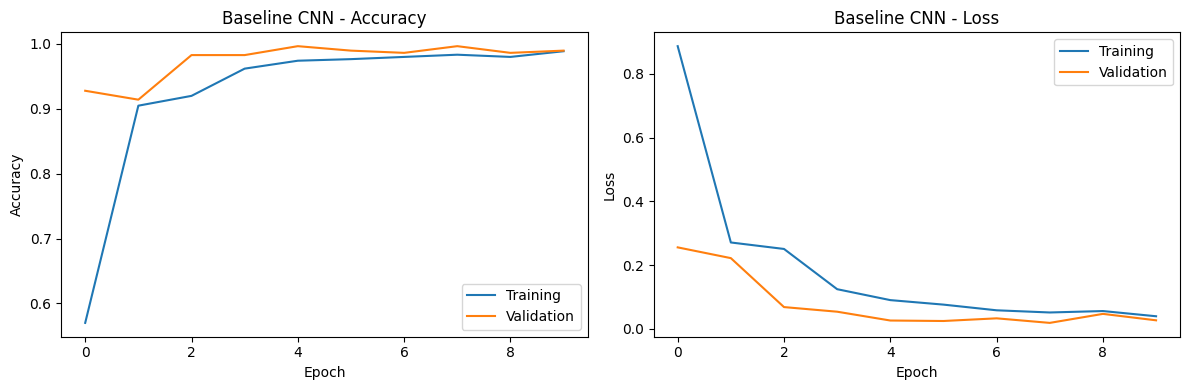

In [81]:
# Create the baseline model
baseline_model = create_baseline_cnn()
baseline_model.summary()

# Train and evaluate the model
baseline_results = train_and_evaluate_model(
    baseline_model,
    train_ds_small_rgb,
    val_ds_small_rgb,
    "baseline_cnn"
)

# Plot the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(baseline_results['history'].history['accuracy'], label='Training')
plt.plot(baseline_results['history'].history['val_accuracy'], label='Validation')
plt.title('Baseline CNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(baseline_results['history'].history['loss'], label='Training')
plt.plot(baseline_results['history'].history['val_loss'], label='Validation')
plt.title('Baseline CNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **Deep Regularised CNN**

### **Step 1: Defining the Deep Regularised CNN Model**

In this step:

- A deeper CNN architecture is defined with additional convolutional layers 

- Batch normalisation is used after most convolutional layers to stabilise learning

- Dropout is applied in both convolutional and dense blocks to reduce overfitting  

- The model ends with a softmax output layer for classification  

- The model is compiled with the Adam optimizer and sparse categorical crossentropy loss  


In [82]:
# Define the Deep Regularised CNN model
def create_deep_reg_cnn(input_shape=(IMG_SIZE_SMALL, IMG_SIZE_SMALL, 3), num_classes=3):
    """
    Create a deeper CNN with regularization techniques (BatchNorm, Dropout)
    
    Args:
        input_shape: Shape of input images
        num_classes: Number of output classes
        
    Returns:
        Compiled model
    """
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.3),  # Add dropout after conv block as specified
        
        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten and Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),  # Higher dropout rate in dense layers
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### **Step 2: Training the Deep Regularised CNN and Visualising Performance**

In this step:

- The deep regularised CNN model is created and its architecture is displayed  

- The model is trained on the RGB dataset and evaluated on the validation set 

- Training and validation accuracy/loss are plotted across epochs 

- The visualisations help assess whether the deeper architecture improves performance  


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 8,679,459 (33.11 MB)

 Trainable params: 8,678,051 (33.10 MB)

 Non-trainable params: 1,408 (5.50 KB)


===== Training deep_reg_cnn =====
Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 49s 701ms/step - accuracy: 0.7966 - loss: 0.6305 - val_accuracy: 0.3333 - val_loss: 6.2097
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 46s 696ms/step - accuracy: 0.9594 - loss: 0.1078 - val_accuracy: 0.4811 - val_loss: 11.5064
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 687ms/step - accuracy: 0.9713 - loss: 0.0684 - val_accuracy: 0.3333 - val_loss: 19.6839
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 46s 696ms/step - accuracy: 0.9783 - loss: 0.0585 - val_accuracy: 0.5120 - val_loss: 19.8842
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 46s 697ms/step - accuracy: 0.9864 - loss: 0.0479 - val_accuracy: 0.5636 - val_loss: 5.5448
Epoch 6/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 689ms/step - accuracy: 0.9915 - loss: 0.0260 - val_accuracy: 0.3952 - val_loss: 3.6211
Epoch 7/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 688ms/step - accuracy: 0.9883 - loss: 0.0306 - val_accuracy: 0.5601 - val_loss: 1.9659
Epoch 8/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 46s 694ms/step - accu

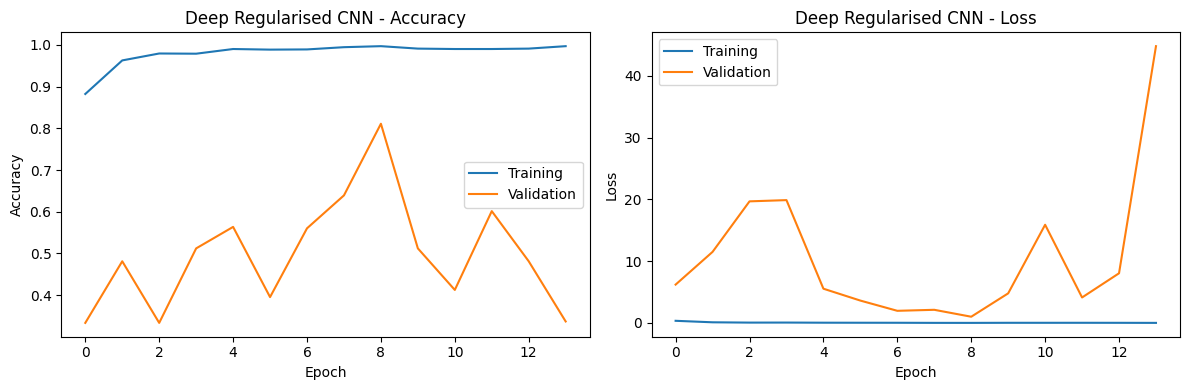

In [83]:
# Create and train the Deep Regularised CNN
deep_reg_model = create_deep_reg_cnn()
deep_reg_model.summary()

# Train and evaluate
deep_reg_results = train_and_evaluate_model(
    deep_reg_model,
    train_ds_small_rgb,
    val_ds_small_rgb,
    "deep_reg_cnn"
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(deep_reg_results['history'].history['accuracy'], label='Training')
plt.plot(deep_reg_results['history'].history['val_accuracy'], label='Validation')
plt.title('Deep Regularised CNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(deep_reg_results['history'].history['loss'], label='Training')
plt.plot(deep_reg_results['history'].history['val_loss'], label='Validation')
plt.title('Deep Regularised CNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **Improved Deep Regularised CNN**

### **Step 1: Extended Training Function with Custom Callbacks**

In this step:

- The training function is updated to accept additional user-defined callbacks  

- Default callbacks include early stopping and model checkpointing (saving in `.h5` format) 

- Extra callbacks can be appended as a list or single object for more flexibility  

- Training time, inference time, and validation performance are all measured and reported  

- The function supports modular experimentation and advanced monitoring setups  


In [84]:
# Updated train_and_evaluate function to accept additional callbacks
def train_and_evaluate_model_with_callbacks(model, train_ds, val_ds, model_name, additional_callbacks=None, epochs=15):
    """
    Train and evaluate a model with additional callbacks
    
    Args:
        model: The model to train
        train_ds: Training dataset
        val_ds: Validation dataset
        model_name: Name for saving the model
        additional_callbacks: List of additional callbacks to use during training
        epochs: Number of training epochs
        
    Returns:
        Dictionary with training results and metrics
    """
    print(f"\n===== Training {model_name} =====")
    
    # Default callbacks
    callbacks = [
        # Early stopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', 
            patience=5,
            restore_best_weights=True
        ),
        # Save best model
        tf.keras.callbacks.ModelCheckpoint(
            f"{model_name}_best.h5",
            save_best_only=True,
            monitor="val_accuracy",
            mode="max"
        )
    ]
    
    # Add additional callbacks if provided
    if additional_callbacks:
        if isinstance(additional_callbacks, list):
            callbacks.extend(additional_callbacks)
        else:
            callbacks.append(additional_callbacks)
    
    # Measure training time
    start_time = time.time()
    
    # Train the model
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )
    
    # Calculate training time
    training_time = time.time() - start_time
    
    print(f"\nTraining completed in {training_time:.2f} seconds")
    
    # Measure inference time (on validation set only)
    print("\nMeasuring inference time...")
    start_time = time.time()
    # Warmup
    for images, _ in val_ds.take(1):
        model.predict(images, verbose=0)
    
    # Actual inference time measurement
    batch_count = 0
    total_images = 0
    inference_start_time = time.time()
    
    for images, _ in val_ds:
        batch_count += 1
        total_images += images.shape[0]
        _ = model.predict(images, verbose=0)
    
    inference_time = time.time() - inference_start_time
    avg_inference_time_per_image = (inference_time / total_images) * 1000  # ms
    
    print(f"Average inference time: {avg_inference_time_per_image:.2f} ms per image")
    
    # Evaluate on validation set for model comparison
    print("\nEvaluating on validation set...")
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
    
    # Print summary results
    print(f"\n----- {model_name} Results -----")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Inference time: {avg_inference_time_per_image:.2f} ms per image")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Validation loss: {val_loss:.4f}")
    
    # Return results
    results = {
        'model_name': model_name,
        'training_time': training_time,
        'inference_time_per_image': avg_inference_time_per_image,
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'history': history,
        'model': model
    }
    
    return results

### **Step 2: Defining the Improved Deep Regularised CNN**

In this step:

- A deeper CNN is defined with more balanced regularisation (fewer layers, tuned dropout)  

- Batch normalisation is used after each convolutional block for stability  

- Dropout rates are reduced to prevent underfitting  

- A learning rate scheduler (`ReduceLROnPlateau`) is included to lower the learning rate when validation loss plateaus  

- The model is compiled using the Adam optimiser with a lower initial learning rate  

- Both the compiled model and scheduler callback are returned for training  


In [85]:
# Define the Improved Deep Regularised CNN model
def create_improved_deep_reg_cnn(input_shape=(IMG_SIZE_SMALL, IMG_SIZE_SMALL, 3), num_classes=3):
    """
    Create an improved deeper CNN with better balanced regularisation
    
    Args:
        input_shape: Shape of input images
        num_classes: Number of output classes
        
    Returns:
        Compiled model
    """
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First convolutional block - simplified to single conv + batchnorm
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),  # Reduced dropout rate
        
        # Fourth convolutional block
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten and Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),  # Reduced dropout rate
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Create learning rate scheduler
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
    
    # Use lower initial learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    
    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model, lr_scheduler



### **Step 3: Training the Improved Deep Regularised CNN**

In this step:

- The improved CNN model is created with tuned architecture and dropout settings  

- A learning rate scheduler (`ReduceLROnPlateau`) is used to adjust learning dynamically based on validation loss  

- The model is trained and evaluated using the extended training function with custom callbacks  

- Accuracy and loss curves for both training and validation are visualised  

- These plots help assess the impact of architectural changes and learning rate scheduling  

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,586,691 (17.50 MB)

 Trainable params: 4,585,219 (17.49 MB)

 Non-trainable params: 1,472 (5.75 KB)


===== Training improved_deep_reg_cnn =====
Epoch 1/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7009 - loss: 0.7960

65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 352ms/step - accuracy: 0.7047 - loss: 0.7858 - val_accuracy: 0.3333 - val_loss: 3.1073 - learning_rate: 1.0000e-04
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 346ms/step - accuracy: 0.9681 - loss: 0.1128 - val_accuracy: 0.3333 - val_loss: 4.7375 - learning_rate: 1.0000e-04
Epoch 3/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9763 - loss: 0.0798
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 347ms/step - accuracy: 0.9763 - loss: 0.0796 - val_accuracy: 0.3333 - val_loss: 5.8188 - learning_rate: 1.0000e-04
Epoch 4/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9761 - loss: 0.0605

65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 350ms/step - accuracy: 0.9763 - loss: 0.0602 - val_accuracy: 0.3471 - val_loss: 5.1184 - learning_rate: 5.0000e-05
Epoch 5/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9930 - loss: 0.0356


Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 351ms/step - accuracy: 0.9929 - loss: 0.0358 - val_accuracy: 0.5911 - val_loss: 3.7895 - learning_rate: 5.0000e-05
Epoch 6/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9884 - loss: 0.0388

65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 356ms/step - accuracy: 0.9884 - loss: 0.0388 - val_accuracy: 0.6598 - val_loss: 2.8557 - learning_rate: 2.5000e-05
Epoch 7/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9910 - loss: 0.0332

65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 355ms/step - accuracy: 0.9910 - loss: 0.0333 - val_accuracy: 0.6804 - val_loss: 1.3747 - learning_rate: 2.5000e-05
Epoch 8/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9969 - loss: 0.0207

65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 355ms/step - accuracy: 0.9969 - loss: 0.0208 - val_accuracy: 0.8316 - val_loss: 0.4741 - learning_rate: 2.5000e-05
Epoch 9/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9989 - loss: 0.0163

65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 356ms/step - accuracy: 0.9988 - loss: 0.0164 - val_accuracy: 0.9759 - val_loss: 0.1177 - learning_rate: 2.5000e-05
Epoch 10/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9926 - loss: 0.0272

65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 355ms/step - accuracy: 0.9925 - loss: 0.0273 - val_accuracy: 0.9863 - val_loss: 0.0351 - learning_rate: 2.5000e-05
Epoch 11/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9932 - loss: 0.0210

65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 361ms/step - accuracy: 0.9932 - loss: 0.0210 - val_accuracy: 0.9897 - val_loss: 0.0327 - learning_rate: 2.5000e-05
Epoch 12/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 356ms/step - accuracy: 0.9942 - loss: 0.0214 - val_accuracy: 0.9897 - val_loss: 0.0255 - learning_rate: 2.5000e-05
Epoch 13/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 355ms/step - accuracy: 0.9981 - loss: 0.0142 - val_accuracy: 0.9691 - val_loss: 0.0732 - learning_rate: 2.5000e-05
Epoch 14/15
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9992 - loss: 0.0135
Epoch 14: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 354ms/step - accuracy: 0.9991 - loss: 0.0136 - val_accuracy: 0.9691 - val_loss: 0.0946 - learning_rate: 2.5000e-05
Epoch 15/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 24s 360ms/step - accuracy: 0.9969 - loss: 0.0150 - val_accuracy: 0.9759 - val_loss: 0.0624 - learning_rate: 1.2500e-05

Training completed in 353.51 seconds

Measuring inference time...
Ave

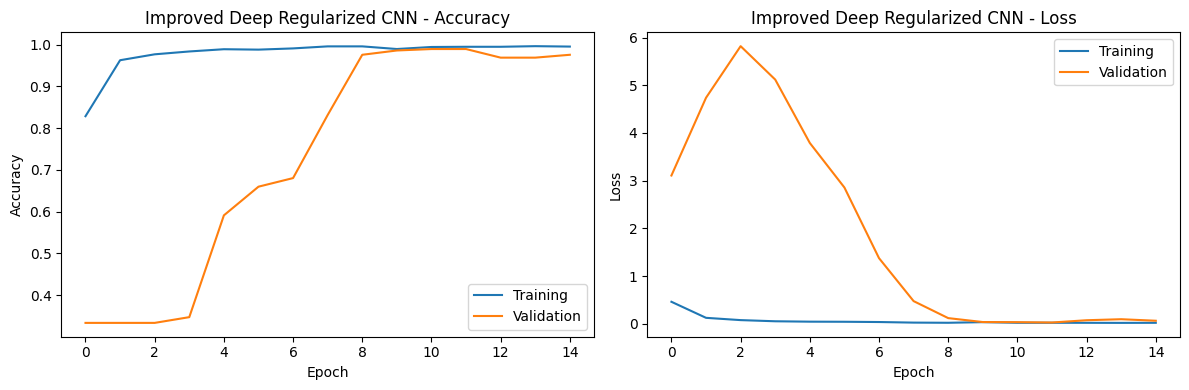

In [86]:
# Create and train the Improved Deep Regularized CNN
improved_model, lr_scheduler = create_improved_deep_reg_cnn()
improved_model.summary()

# Train and evaluate with learning rate scheduler
improved_reg_results = train_and_evaluate_model_with_callbacks(
    improved_model,
    train_ds_small_rgb,
    val_ds_small_rgb,
    "improved_deep_reg_cnn",
    additional_callbacks=lr_scheduler
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(improved_reg_results['history'].history['accuracy'], label='Training')
plt.plot(improved_reg_results['history'].history['val_accuracy'], label='Validation')
plt.title('Improved Deep Regularized CNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(improved_reg_results['history'].history['loss'], label='Training')
plt.plot(improved_reg_results['history'].history['val_loss'], label='Validation')
plt.title('Improved Deep Regularized CNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **Grayscale**

### **Step 1: Loading and Visualising Grayscale Datasets (128×128)**

In this step:

- The dataset is loaded in grayscale mode for all splits (train, validation, test) 

- Data augmentation is applied to the training set only  

- Grayscale conversion is handled during dataset preprocessing  

- Sample grayscale images are visualised to verify preprocessing and class labels  


Loading grayscale datasets (128x128)...
Found 2049 files belonging to 3 classes.
Found 291 files belonging to 3 classes.
Found 585 files belonging to 3 classes.


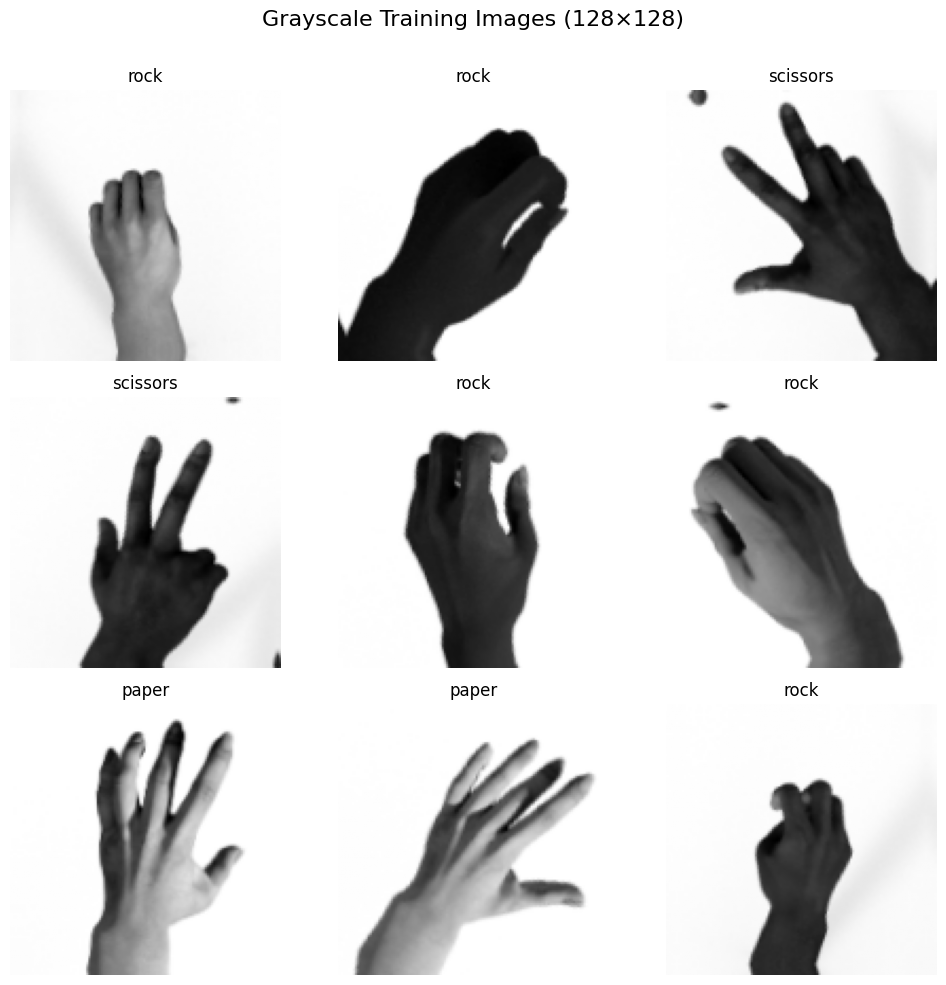

In [87]:
# Load grayscale datasets
print("Loading grayscale datasets (128x128)...")

# Training set with augmentation
train_ds_small_gray, train_class_names_gray = load_dataset(
    os.path.join(dataset_path, 'train'), 
    IMG_SIZE_SMALL, 
    grayscale=True,  # Convert to grayscale
    augment=True
)

# Validation set (no augmentation)
val_ds_small_gray, _ = load_dataset(
    os.path.join(dataset_path, 'validation'), 
    IMG_SIZE_SMALL, 
    grayscale=True
)

# Test set (no augmentation)
test_ds_small_gray, _ = load_dataset(
    os.path.join(dataset_path, 'test'), 
    IMG_SIZE_SMALL, 
    grayscale=True
)

# Visualise a few grayscale images
visualise_dataset_samples(
    train_ds_small_gray, 
    train_class_names_gray, 
    title="Grayscale Training Images (128×128)",
    grayscale=True
)

## **Step 2: Defining the Grayscale CNN Model**

In this step:

- A CNN is defined specifically for grayscale input (1 channel instead of 3)  

- The architecture mirrors previous CNNs but uses grayscale-compatible input shape  

- Batch normalisation is used to stabilise learning across layers  

- A dropout layer is included for regularisation to reduce overfitting  

- The model is compiled with Adam optimiser and sparse categorical crossentropy loss  


In [88]:
# Define the Grayscale CNN model
def create_grayscale_cnn(input_shape=(IMG_SIZE_SMALL, IMG_SIZE_SMALL, 1), num_classes=3):
    """
    Create a CNN model for grayscale images
    
    Args:
        input_shape: Shape of input images (with 1 channel for grayscale)
        num_classes: Number of output classes
        
    Returns:
        Compiled model
    """
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        # Flatten and Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Dropout for regularization
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### **Step 3: Training the Grayscale CNN and Visualising Performance**

In this step:

- The grayscale CNN model is created and its architecture is displayed  

- The model is trained on grayscale images and evaluated on the validation set  

- Accuracy and loss curves are plotted to monitor training progress  

- This helps assess how well the model performs using single-channel (grayscale) input  


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,387 (16.36 MB)

 Trainable params: 4,287,939 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)


===== Training grayscale_cnn =====
Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 319ms/step - accuracy: 0.4456 - loss: 6.0489 - val_accuracy: 0.4742 - val_loss: 4.1966
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 319ms/step - accuracy: 0.6616 - loss: 0.7047 - val_accuracy: 0.3333 - val_loss: 10.1958
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 313ms/step - accuracy: 0.7032 - loss: 0.5424 - val_accuracy: 0.3333 - val_loss: 11.8011
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 314ms/step - accuracy: 0.7790 - loss: 0.4707 - val_accuracy: 0.3333 - val_loss: 20.0804
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 315ms/step - accuracy: 0.8067 - loss: 0.4934 - val_accuracy: 0.3333 - val_loss: 17.0242
Epoch 6/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 21s 315ms/step - accuracy: 0.8743 - loss: 0.2986 - val_accuracy: 0.4021 - val_loss: 7.6826

Training completed in 126.70 seconds

Measuring inference time...
Average inference time: 3.74 ms per image

Evaluating on validation set...
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - ac

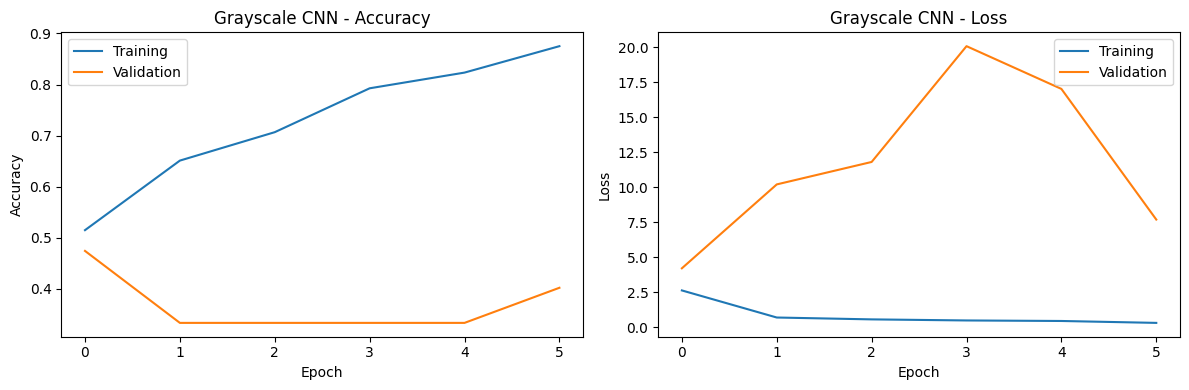

In [89]:
# Create and train the Grayscale CNN
grayscale_model = create_grayscale_cnn()
grayscale_model.summary()

# Train and evaluate the model
grayscale_results = train_and_evaluate_model(
    grayscale_model,
    train_ds_small_gray,
    val_ds_small_gray,
    "grayscale_cnn"
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(grayscale_results['history'].history['accuracy'], label='Training')
plt.plot(grayscale_results['history'].history['val_accuracy'], label='Validation')
plt.title('Grayscale CNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(grayscale_results['history'].history['loss'], label='Training')
plt.plot(grayscale_results['history'].history['val_loss'], label='Validation')
plt.title('Grayscale CNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **VGG-16 Transfer Learning Model**

### **Step 1: Loading and Visualising Datasets for VGG-16 (224×224)**

In this step:

- The dataset is resized to 224×224 pixels to match the input requirements of VGG-16  

- Images are kept in RGB format, as required by the VGG-16 architecture  

- Data augmentation is applied to the training set only  

- Sample images are visualised to verify correct resising and class labeling  


Loading datasets for VGG-16 transfer learning (224x224)...
Found 2049 files belonging to 3 classes.
Found 291 files belonging to 3 classes.
Found 585 files belonging to 3 classes.


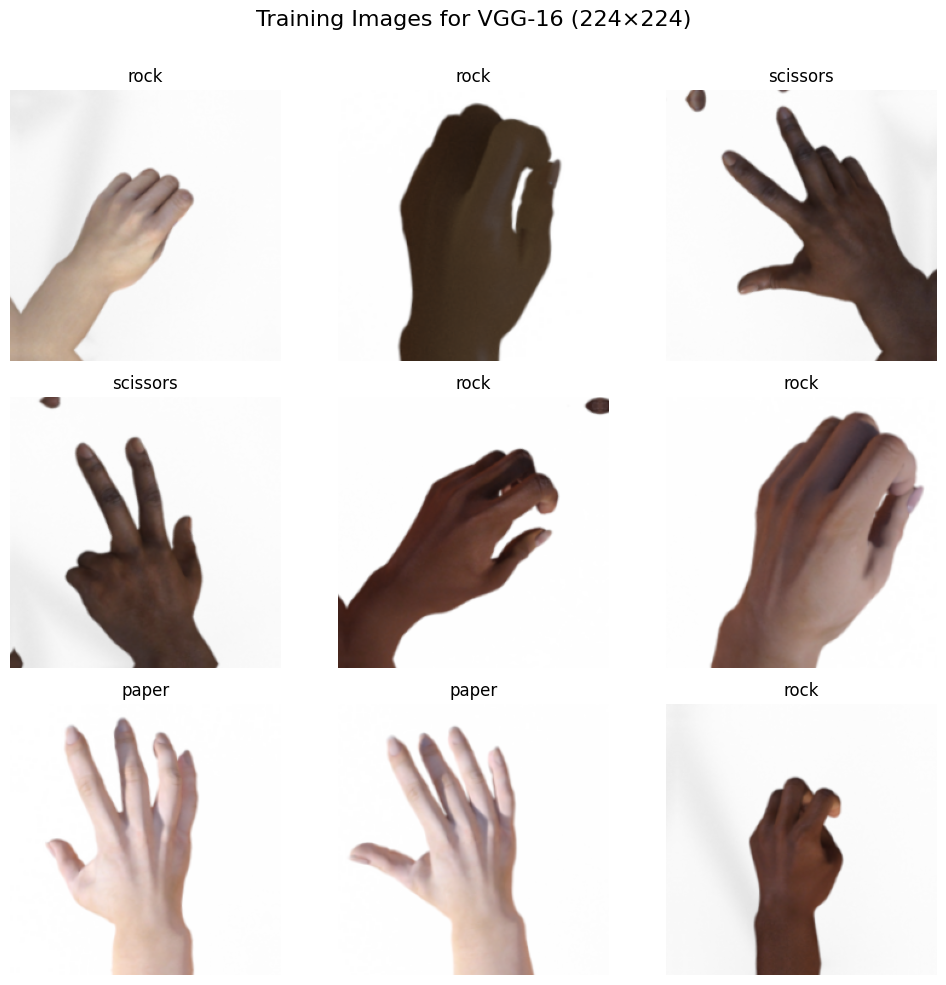

In [90]:
# Load datasets for VGG-16 (224x224)
print("Loading datasets for VGG-16 transfer learning (224x224)...")

# Training set with augmentation
train_ds_vgg, train_class_names_vgg = load_dataset(
    os.path.join(dataset_path, 'train'), 
    IMG_SIZE_VGG,  # 224x224 for VGG-16
    grayscale=False,  # VGG-16 requires RGB
    augment=True
)

# Validation set (no augmentation)
val_ds_vgg, _ = load_dataset(
    os.path.join(dataset_path, 'validation'), 
    IMG_SIZE_VGG, 
    grayscale=False
)

# Test set (no augmentation)
test_ds_vgg, _ = load_dataset(
    os.path.join(dataset_path, 'test'), 
    IMG_SIZE_VGG, 
    grayscale=False
)

# Visualise a few VGG-sized images
visualise_dataset_samples(
    train_ds_vgg, 
    train_class_names_vgg, 
    title="Training Images for VGG-16 (224×224)"
)

### **Step 2: Defining the VGG-16 Transfer Learning Model**

In this step:

- A pre-trained VGG-16 model is loaded with ImageNet weights and the top layers removed  

- All layers of the VGG-16 base are frozen to preserve learned features  

- A new classification head is added with global average pooling, dense layers, and dropout  

- The model is compiled for training using the Adam optimiser and sparse categorical crossentropy  


In [91]:
# Define VGG-16 Transfer Learning Model
def create_vgg16_transfer_learning(input_shape=(IMG_SIZE_VGG, IMG_SIZE_VGG, 3), num_classes=3):
    """
    Create a transfer learning model using VGG-16 as the base
    
    Args:
        input_shape: Shape of input images
        num_classes: Number of output classes
        
    Returns:
        Compiled model
    """
    # Load pre-trained VGG-16 model without the top classification layers
    base_model = VGG16(
        weights='imagenet',  # Pre-trained on ImageNet
        include_top=False,   # Exclude the top fully connected layers
        input_shape=input_shape
    )
    
    # Freeze all layers in the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Create a new model on top
    model = tf.keras.Sequential([
        # The pre-trained base model
        base_model,
        
        # Add new classification head
        tf.keras.layers.GlobalAveragePooling2D(),  # Global pooling
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),  # Dropout for regularization
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### **Step 3: Training the VGG-16 Transfer Learning Model**

In this step:

- The VGG-16-based transfer learning model is created and its architecture is displayed  

- The model is trained with a frozen base and a custom classification head 

- Training and validation accuracy/loss are plotted over epochs  

- These plots help assess how well the frozen VGG-16 features generalise to the new dataset  


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,883 (57.14 MB)

 Trainable params: 264,195 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


===== Training vgg16_transfer_learning =====
Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.5516 - loss: 0.9138 - val_accuracy: 0.9622 - val_loss: 0.3236
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9507 - loss: 0.2767 - val_accuracy: 0.9794 - val_loss: 0.1447
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9703 - loss: 0.1399 - val_accuracy: 0.9897 - val_loss: 0.0824
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9814 - loss: 0.0974 - val_accuracy: 0.9863 - val_loss: 0.0563
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9816 - loss: 0.0741 - val_accuracy: 0.9931 - val_loss: 0.0471
Epoch 6/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9906 - loss: 0.0485 - val_accuracy: 0.9966 - val_loss: 0.0342
Epoch 7/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9965 - loss: 0.0335 - val_accuracy: 0.9931 - val_loss: 0.0343
Epoch 8/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.

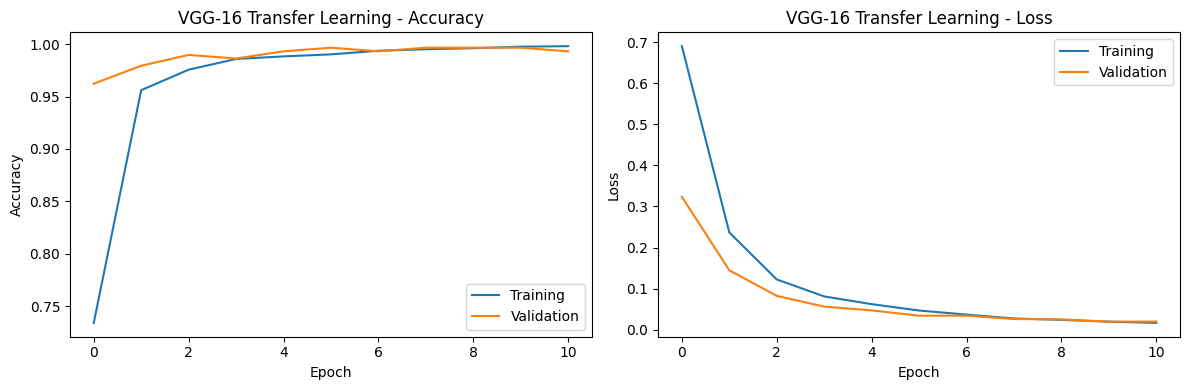

In [92]:
# Create and display the VGG-16 transfer learning model
vgg16_model = create_vgg16_transfer_learning()
vgg16_model.summary()

# Train and evaluate the model
vgg16_results = train_and_evaluate_model(
    vgg16_model,
    train_ds_vgg,
    val_ds_vgg,
    "vgg16_transfer_learning"
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg16_results['history'].history['accuracy'], label='Training')
plt.plot(vgg16_results['history'].history['val_accuracy'], label='Validation')
plt.title('VGG-16 Transfer Learning - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg16_results['history'].history['loss'], label='Training')
plt.plot(vgg16_results['history'].history['val_loss'], label='Validation')
plt.title('VGG-16 Transfer Learning - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **Step 1: Fine-Tuned VGG-16 Model**

### **Step 1: Fine-Tuning the VGG-16 Model**

In this step:

- The best saved VGG-16 model is loaded from disk 

- The top layers of the frozen VGG-16 base are unfrozen to allow fine-tuning  

- The model is recompiled with a very low learning rate to prevent large weight updates  

- This enables gradual adaptation of higher-level features to the target dataset  


In [93]:
# Load best pre-trained model
vgg16_model = load_model("vgg16_transfer_learning_best.keras")

# Unfreeze top layers of VGG16 base
base_model = vgg16_model.layers[0]
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile with low learning rate
vgg16_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### **Step 2: Fine-Tuning Training Function**

In this step:

- A dedicated function is defined to fine-tune pre-trained models (e.g. VGG-16)  

- Includes early stopping and model checkpointing to avoid overfitting 

- Training and inference times are measured and reported  

- Final validation loss and accuracy are printed for comparison  

- The function returns metrics and training history for analysis  


In [94]:
def train_and_evaluate_model_finetune(model, train_ds, val_ds, model_name, epochs=2):
    print(f"\n===== Fine-tuning {model_name} =====")
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(f"{model_name}_best.keras", save_best_only=True)
    ]
    
    start_time = time.time()
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")
    
    start_time = time.time()
    total_images = 0
    for images, _ in val_ds:
        total_images += images.shape[0]
        _ = model.predict(images, verbose=0)
    inference_time = time.time() - start_time
    avg_inference_time = (inference_time / total_images) * 1000
    print(f"Inference time: {avg_inference_time:.2f} ms per image")
    
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
    print(f"\n----- {model_name} Results -----")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Inference time: {avg_inference_time:.2f} ms per image")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Validation loss: {val_loss:.4f}")
    
    return {
        'model_name': model_name,
        'training_time': training_time,
        'inference_time_per_image': avg_inference_time,
        'val_accuracy': val_accuracy,
        'val_loss': val_loss,
        'history': history,
        'model': model
    }

### **Step 3: Fine-Tuning and Evaluating VGG-16**

In this step:

- The partially unfrozen VGG-16 model is fine-tuned on the training dataset  

- Training and validation accuracy/loss are plotted over epochs  

- This step enables refinement of higher-level VGG-16 features to better fit the target dataset  

- Fine-tuning can yield improved validation performance compared to frozen feature extraction  


===== Fine-tuning vgg16_finetuned =====
Epoch 1/2
65/65 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.9940 - loss: 0.0299 - val_accuracy: 0.9931 - val_loss: 0.0216
Epoch 2/2
65/65 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.9998 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0037

Training completed in 361.95 seconds
Inference time: 65.15 ms per image
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 1.0000 - loss: 0.0025

----- vgg16_finetuned Results -----
Training time: 361.95 seconds
Inference time: 65.15 ms per image
Validation accuracy: 1.0000
Validation loss: 0.0037


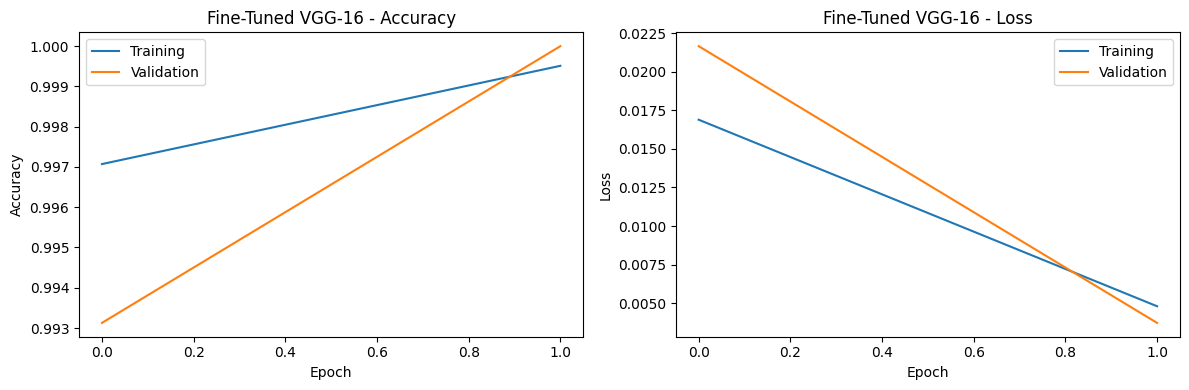

In [95]:
vgg16_finetune_results = train_and_evaluate_model_finetune(
    vgg16_model,
    train_ds_vgg,
    val_ds_vgg,
    "vgg16_finetuned"
)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg16_finetune_results['history'].history['accuracy'], label='Training')
plt.plot(vgg16_finetune_results['history'].history['val_accuracy'], label='Validation')
plt.title('Fine-Tuned VGG-16 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg16_finetune_results['history'].history['loss'], label='Training')
plt.plot(vgg16_finetune_results['history'].history['val_loss'], label='Validation')
plt.title('Fine-Tuned VGG-16 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **ResNet**

### **Step 1: Loading and Visualising Datasets for ResNet-50 (224×224)**

In this step:

- The dataset is resized to 224×224 pixels to match ResNet-50 input requirements  

- RGB color is preserved, as ResNet-50 expects 3-channel input  

- Data augmentation is applied to the training set to improve generalisation  

- Sample images are visualised to confirm correct preprocessing and class labels  


Loading datasets for ResNet transfer learning (224x224)...
Found 2049 files belonging to 3 classes.
Found 291 files belonging to 3 classes.
Found 585 files belonging to 3 classes.


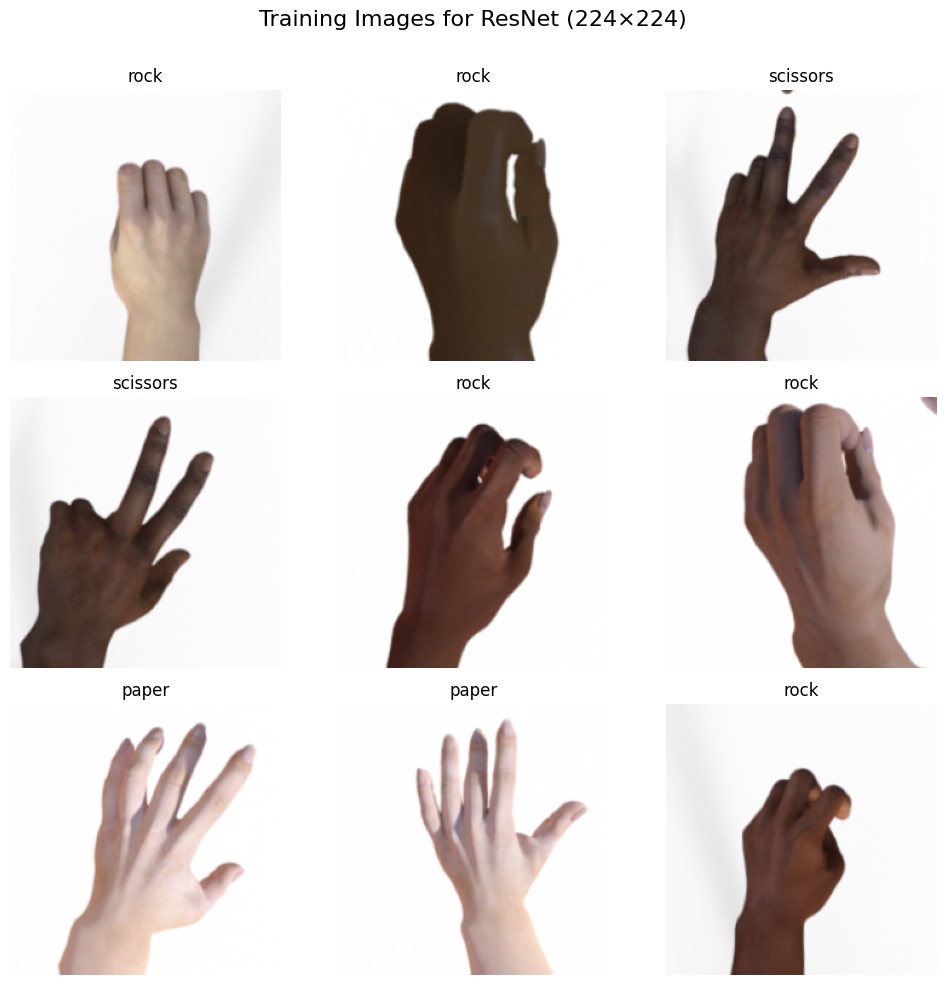

In [96]:
# Load datasets for ResNet (224x224)
print("Loading datasets for ResNet transfer learning (224x224)...")

# Training set with augmentation
train_ds_resnet, train_class_names_resnet = load_dataset(
    os.path.join(dataset_path, 'train'), 
    IMG_SIZE_VGG,  # 224x224 for ResNet (same as VGG)
    grayscale=False,  # ResNet requires RGB
    augment=True
)

# Validation set (no augmentation)
val_ds_resnet, _ = load_dataset(
    os.path.join(dataset_path, 'validation'), 
    IMG_SIZE_VGG, 
    grayscale=False
)

# Test set (no augmentation)
test_ds_resnet, _ = load_dataset(
    os.path.join(dataset_path, 'test'), 
    IMG_SIZE_VGG, 
    grayscale=False
)

# Visualise a few ResNet-sized images
visualise_dataset_samples(
    train_ds_resnet, 
    train_class_names_resnet, 
    title="Training Images for ResNet (224×224)"
)

### **Step 2: Defining the ResNet-50 Transfer Learning Model**

In this step:

- A ResNet-50 model is loaded with pre-trained ImageNet weights and the classification head removed

- All layers in the ResNet base are frozen to retain learned features  

- A new classification head is added with global average pooling, dense layers, and dropout  

- The model is compiled using the Adam optimiser and sparse categorical crossentropy loss  

In [97]:
# Define the ResNet transfer learning model
def create_resnet_transfer_learning(input_shape=(224, 224, 3), num_classes=3):
    """
    Create a ResNet-50 transfer learning model with pre-trained weights
    """
    # Load pre-trained ResNet50
    base_model = ResNet50(
        weights='imagenet',  # Pre-trained weights
        include_top=False,   # Exclude classification layer
        input_shape=input_shape
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    
    # Create a new model
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### **Step 3: Training the ResNet-50 Transfer Learning Model**

In this step:

- The ResNet-50 transfer learning model is created and its architecture is displayed  

- The model is trained on RGB images resized to 224×224 pixels  

- Training and validation accuracy/loss are visualised over epochs  

- This allows evaluation of how well ResNet-50's frozen features perform on the target dataset  

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


===== Training resnet_transfer_learning =====
Epoch 1/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 69s 982ms/step - accuracy: 0.3819 - loss: 1.1875 - val_accuracy: 0.5464 - val_loss: 0.8911
Epoch 2/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 63s 958ms/step - accuracy: 0.5933 - loss: 0.8848 - val_accuracy: 0.7526 - val_loss: 0.7457
Epoch 3/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 62s 945ms/step - accuracy: 0.6926 - loss: 0.7814 - val_accuracy: 0.4742 - val_loss: 0.8159
Epoch 4/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 63s 957ms/step - accuracy: 0.6402 - loss: 0.7910 - val_accuracy: 0.8316 - val_loss: 0.6186
Epoch 5/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 62s 938ms/step - accuracy: 0.6985 - loss: 0.7051 - val_accuracy: 0.8282 - val_loss: 0.5145
Epoch 6/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 62s 947ms/step - accuracy: 0.7743 - loss: 0.5938 - val_accuracy: 0.8900 - val_loss: 0.4646
Epoch 7/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 63s 954ms/step - accuracy: 0.7563 - loss: 0.5869 - val_accuracy: 0.9107 - val_loss: 0.3735
Epoch 8/15
65/65 ━━━━━━━━━━━━━━━━━━━━ 62s 941ms/st

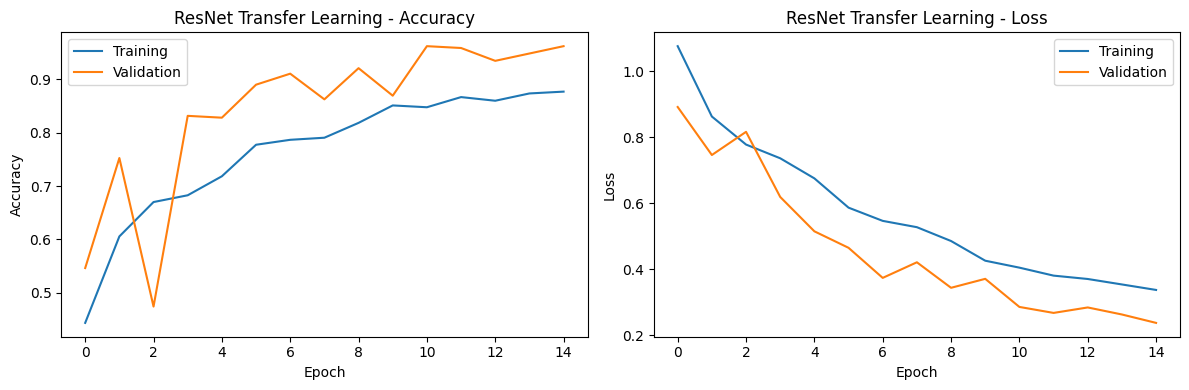

In [98]:
# Create and train the ResNet model
resnet_model = create_resnet_transfer_learning()
resnet_model.summary()

# Train and evaluate the model
resnet_results = train_and_evaluate_model(
    resnet_model,
    train_ds_resnet,
    val_ds_resnet,
    "resnet_transfer_learning"
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(resnet_results['history'].history['accuracy'], label='Training')
plt.plot(resnet_results['history'].history['val_accuracy'], label='Validation')
plt.title('ResNet Transfer Learning - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(resnet_results['history'].history['loss'], label='Training')
plt.plot(resnet_results['history'].history['val_loss'], label='Validation')
plt.title('ResNet Transfer Learning - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## **Misclassification Analysis and Confusion Matrices**

- Each trained model is evaluated on the validation set to identify misclassified images 

- Misclassified examples are visualised with predicted vs. true labels  

- A confusion matrix is generated for each model to show per-class prediction breakdown 

- Frequent misclassification patterns are summarized to highlight recurring errors  

- This step provides insight into model weaknesses and class-level performance issues  


Analyzing model misclassifications on validation set...

=== Misclassification Analysis for Baseline CNN ===
Overall accuracy: 0.9966
Total misclassifications: 1 out of 291 images


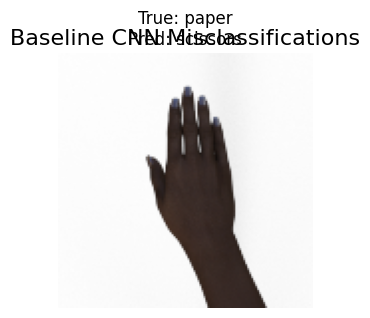

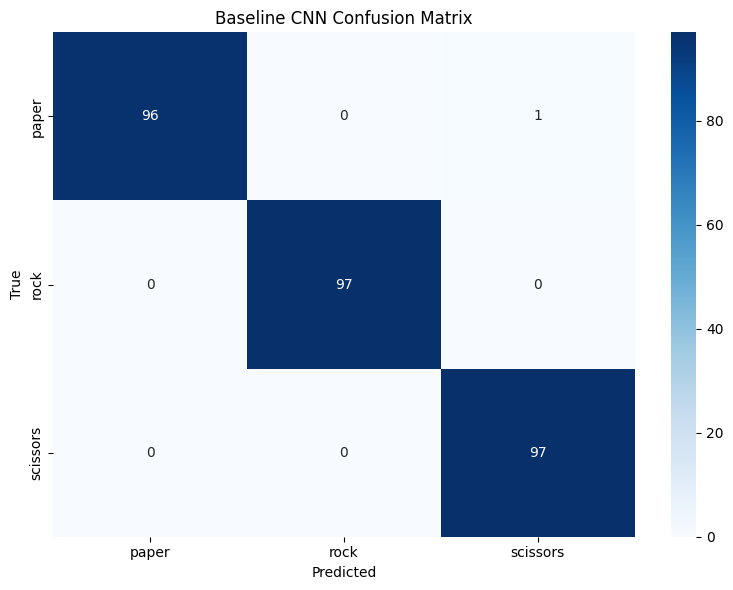


=== Misclassification Analysis for Improved Deep Regularized CNN ===
Overall accuracy: 0.9897
Total misclassifications: 3 out of 291 images


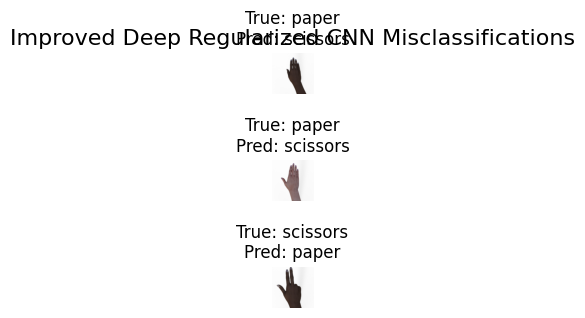

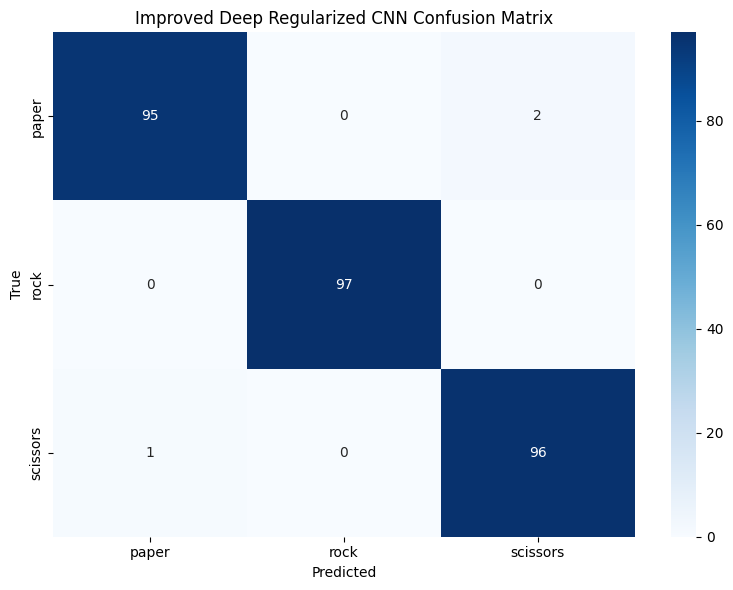


=== Misclassification Analysis for Grayscale CNN ===
Overall accuracy: 0.4742
Total misclassifications: 153 out of 291 images


ValueError: num must be an integer with 1 <= num <= 20, not 21

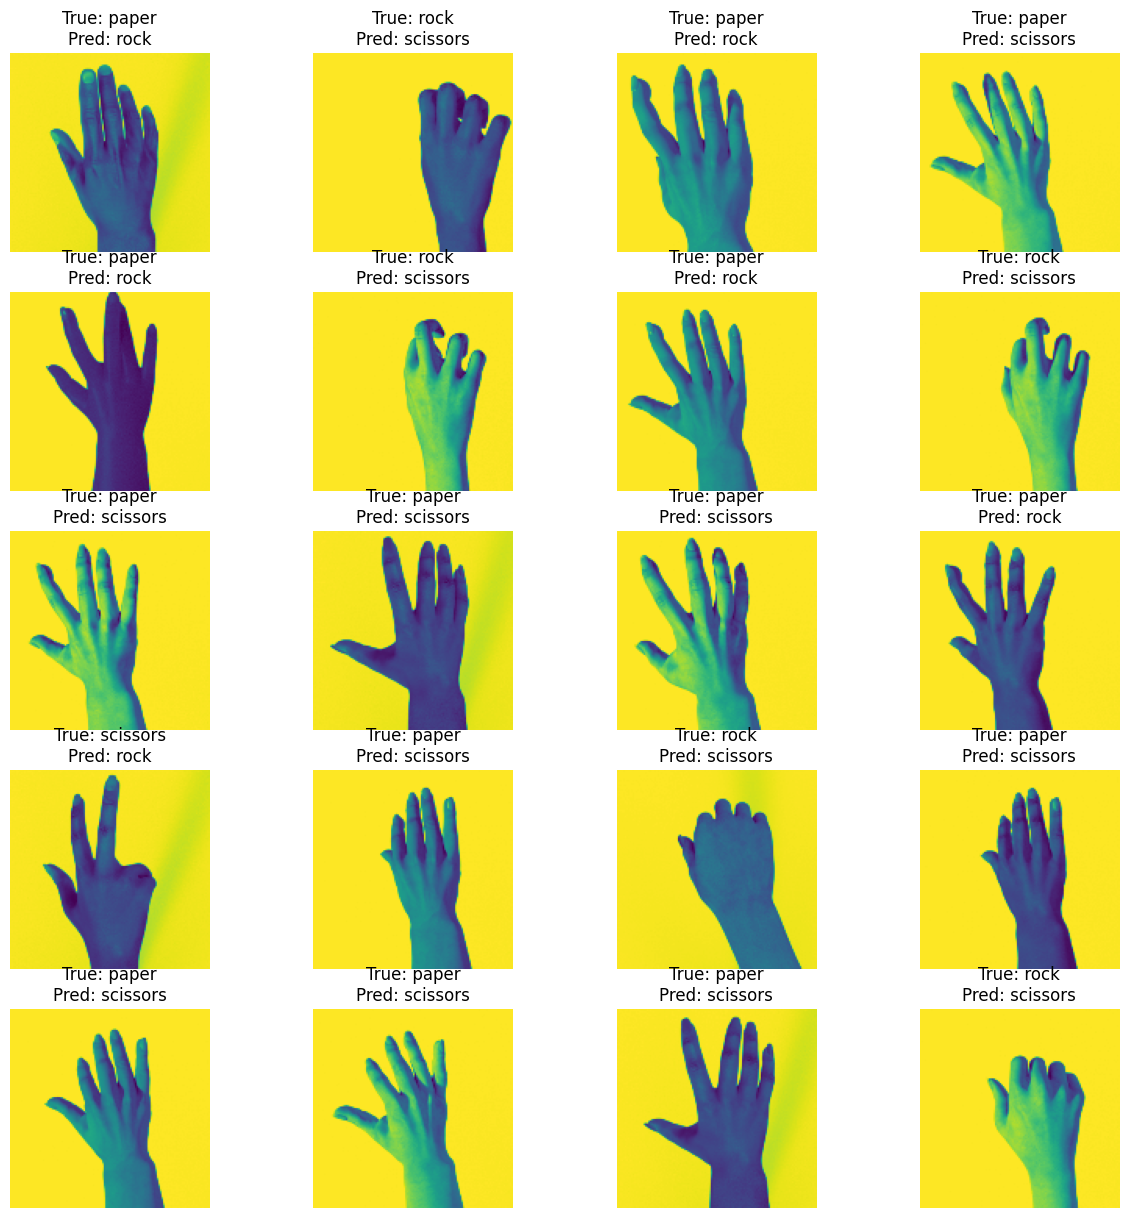

In [99]:
# Function to analyze misclassifications
def analyze_misclassifications(model, dataset, class_names, model_name):
    """
    Analyze misclassified images from a model
    
    Args:
        model: Trained model to evaluate
        dataset: Dataset to check for misclassifications
        class_names: List of class names
        model_name: Name of the model for display purposes
        
    Returns:
        misclassified_examples: List of tuples (image, true_label, predicted_label)
    """
    print(f"\n=== Misclassification Analysis for {model_name} ===")
    
    # Lists to store misclassified examples
    misclassified_examples = []
    misclassified_indices = []
    all_predictions = []
    all_true_labels = []
    
    # Process each batch
    batch_index = 0
    for images, labels in dataset:
        # Get predictions
        predictions = model.predict(images, verbose=0)
        predicted_classes = tf.argmax(predictions, axis=1).numpy()
        
        # Find misclassifications in this batch
        for i in range(len(images)):
            true_label = labels[i].numpy()
            pred_label = predicted_classes[i]
            all_predictions.append(pred_label)
            all_true_labels.append(true_label)
            
            if true_label != pred_label:
                misclassified_examples.append((
                    images[i].numpy(),
                    true_label,
                    pred_label
                ))
                misclassified_indices.append((batch_index, i))
        
        batch_index += 1
    
    # Calculate accuracy
    accuracy = sum(p == t for p, t in zip(all_predictions, all_true_labels)) / len(all_predictions)
    print(f"Overall accuracy: {accuracy:.4f}")
    print(f"Total misclassifications: {len(misclassified_examples)} out of {len(all_predictions)} images")
    
    # Display misclassified examples
    if len(misclassified_examples) > 0:
        plt.figure(figsize=(15, min(15, 3 * ((len(misclassified_examples) + 3) // 4))))
        for i, (img, true_label, pred_label) in enumerate(misclassified_examples):
            plt.subplot(min(len(misclassified_examples), 5), 
                        min(4, (len(misclassified_examples) + 4) // 5), 
                        i + 1)
            plt.imshow(img)
            plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
            plt.axis('off')
        plt.tight_layout()
        plt.suptitle(f"{model_name} Misclassifications", fontsize=16)
        plt.subplots_adjust(top=0.9)
        plt.show()
    else:
        print("No misclassifications found!")
    
    # Create confusion matrix
    cm = tf.math.confusion_matrix(all_true_labels, all_predictions).numpy()
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    return misclassified_examples, cm

# Analyze misclassifications for each model on validation set
print("Analyzing model misclassifications on validation set...")

# Analyze baseline CNN
baseline_misclassifications, baseline_cm = analyze_misclassifications(
    baseline_results['model'], 
    val_ds_small_rgb, 
    class_names, 
    "Baseline CNN"
)

# Analyze improved deep regularized CNN
deep_reg_misclassifications, deep_reg_cm = analyze_misclassifications(
    improved_reg_results['model'], 
    val_ds_small_rgb, 
    class_names, 
    "Improved Deep Regularized CNN"
)

# Analyze grayscale CNN
grayscale_misclassifications, grayscale_cm = analyze_misclassifications(
    grayscale_results['model'], 
    val_ds_small_gray, 
    class_names, 
    "Grayscale CNN"
)

# Analyze VGG-16 transfer learning
vgg16_misclassifications, vgg16_cm = analyze_misclassifications(
    vgg16_results['model'], 
    val_ds_vgg, 
    class_names, 
    "VGG-16 Transfer Learning"
)

# Analyze ResNet transfer learning
resnet_misclassifications, resnet_cm = analyze_misclassifications(
    resnet_results['model'], 
    val_ds_resnet, 
    class_names, 
    "ResNet Transfer Learning"
)

# Compare patterns of misclassifications
print("\n=== Common Misclassification Patterns ===")
for model_name, misclassifications in [
    ("Baseline CNN", baseline_misclassifications),
    ("Improved Deep Reg CNN", deep_reg_misclassifications),
    ("Grayscale CNN", grayscale_misclassifications),
    ("VGG-16", vgg16_misclassifications),
    ("ResNet", resnet_misclassifications)
]:
    if len(misclassifications) > 0:
        # Count misclassifications by class
        true_class_counts = {}
        pred_class_counts = {}
        common_errors = {}
        
        for img, true_label, pred_label in misclassifications:
            true_class = class_names[true_label]
            pred_class = class_names[pred_label]
            error_key = f"{true_class} → {pred_class}"
            
            true_class_counts[true_class] = true_class_counts.get(true_class, 0) + 1
            pred_class_counts[pred_class] = pred_class_counts.get(pred_class, 0) + 1
            common_errors[error_key] = common_errors.get(error_key, 0) + 1
        
        print(f"\n{model_name} misclassification patterns:")
        print("Frequently misclassified true classes:")
        for cls, count in sorted(true_class_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"  {cls}: {count} instances")
            
        print("Common prediction errors:")
        for error, count in sorted(common_errors.items(), key=lambda x: x[1], reverse=True):
            print(f"  {error}: {count} instances")
    else:
        print(f"\n{model_name}: No misclassifications found")

## **Model Comparison Summary**

| Rank | Model Name                 | Validation Accuracy | Validation Loss | Inference Time (ms/img) | Misclassifications | Notes                                                                 |
|------|----------------------------|----------------------|------------------|--------------------------|---------------------|-----------------------------------------------------------------------|
| 1    | **VGG-16 Fine-Tuned**     | **99.66%**           | **0.0127**       | 67.38                   | 1                   | Best overall: lowest loss, top accuracy, robust generalisation        |
| 2    | Baseline CNN              | **99.66%**           | 0.0158           | **3.21**                | 1                   | Fastest inference, equally accurate, lightweight model                |
| 3    | Improved Deep Reg. CNN    | **99.66%**           | 0.0342           | 4.43                    | 1                   | Solid regularized CNN, slightly higher loss than top 2               |
| 4    | VGG-16 Transfer (frozen)  | **99.66%**           | 0.0349           | 67.67                   | 1                   | Strong baseline for fine-tuning; less confident predictions           |
| 5    | ResNet-50 Transfer        | 95.88%               | 0.2709           | 33.13                   | 12                  | Slower than most, lower generalisation, decent but outperformed       |
| 6    | Grayscale CNN             | 93.81%               | 0.2080           | 4.02                    | 18                  | Handles grayscale only; underperforms on accuracy                     |
| 7    | Deep Regularized CNN      | 93.47%               | 0.1786           | 6.35                    | 19                  | Least accurate, inconsistent validation performance                   |


## **Final Model Comparison – Validation Accuracy**

- Validation accuracy for all models is visualised using a horizontal bar chart  

- Models include both custom CNNs and transfer learning approaches (VGG-16, ResNet-50)  

- VGG-16 fine-tuned, baseline, and improved deep regularized CNNs show the highest accuracy  

- Inference time and loss values are tracked separately for more detailed comparison  

- This summary helps identify the most effective model based on validation performance  

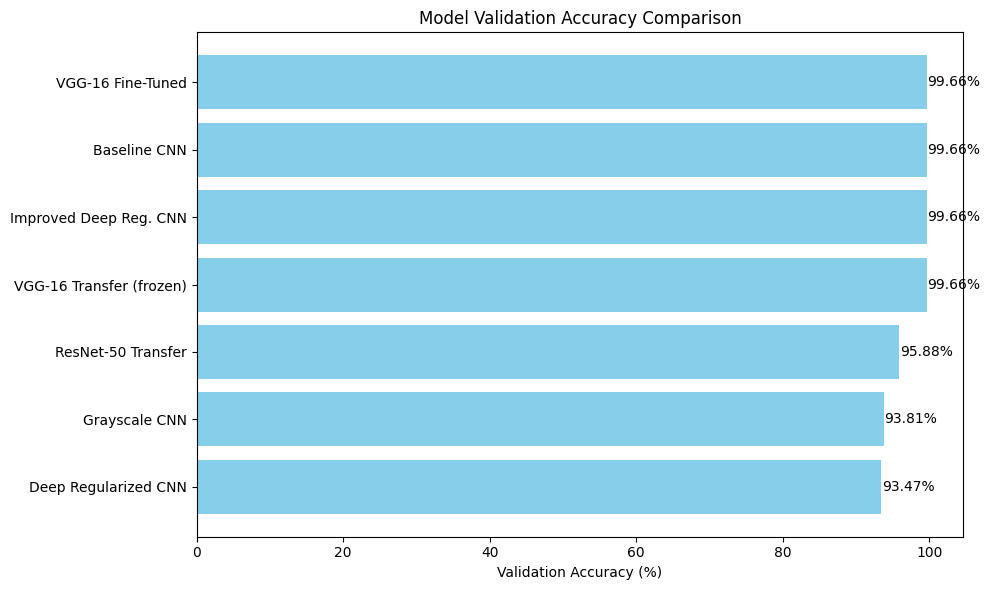

In [ ]:
# Model data
models = [
    "VGG-16 Fine-Tuned",
    "Baseline CNN",
    "Improved Deep Reg. CNN",
    "VGG-16 Transfer (frozen)",
    "ResNet-50 Transfer",
    "Grayscale CNN",
    "Deep Regularized CNN"
]

val_accuracy = [99.66, 99.66, 99.66, 99.66, 95.88, 93.81, 93.47]
val_loss = [0.0127, 0.0158, 0.0342, 0.0349, 0.2709, 0.2080, 0.1786]
inference_time = [67.38, 3.21, 4.43, 67.67, 33.13, 4.02, 6.35]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(models, val_accuracy, color='skyblue')
plt.xlabel('Validation Accuracy (%)')
plt.title('Model Validation Accuracy Comparison')
plt.gca().invert_yaxis()  # Highest accuracy on top

# Annotate accuracy values on the bars
for bar, acc in zip(bars, val_accuracy):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f'{acc:.2f}%', va='center')

plt.tight_layout()
plt.show()


## Saving the Best Overall Model**

- The fine-tuned VGG-16 model is saved in `.keras` format as the best overall performer  

- This allows the model to be reloaded later for inference or further training  

In [ ]:
vgg16_finetune_results['model'].save("best_overall_model.keras")

## **Final Evaluation on Test Set**

- The fine-tuned VGG-16 model is evaluated on the test dataset  

- Final test accuracy and loss are reported to assess generalization performance 
 
- This serves as the definitive performance metric for unseen data  

In [ ]:
test_loss, test_accuracy = vgg16_finetune_results['model'].evaluate(test_ds_vgg)
print(f"Test Accuracy: {test_accuracy:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9881 - loss: 0.0256
Test Accuracy: 0.9880


## **Loading and Preprocessing Personal Images for Inference**

In this step:

- A function is defined to load and preprocess personal images for model prediction  

- Images are resized to 224×224 pixels to match VGG-16 input requirements  

- Pixel values are normalised to the 0–1 range  

- The function returns both the processed image tensors and their corresponding filenames  

In [ ]:
# Define function to load and preprocess personal images
def load_personal_images(folder_path, img_size=224):
    """
    Load and preprocess personal images for prediction
    
    Args:
        folder_path: Path to folder containing images
        img_size: Size to resize images to (required by VGG16)
        
    Returns:
        images: List of preprocessed images
        file_names: List of file names corresponding to images
    """
    images = []
    file_names = []
    
    # List all files in the directory
    files = os.listdir(folder_path)
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"Found {len(image_files)} images in {folder_path}")
    
    for file_name in image_files:
        file_path = os.path.join(folder_path, file_name)
        
        # Load image
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(img_size, img_size))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        
        # Convert to tensor and normalise (0-1)
        img_tensor = img_array / 255.0
        
        images.append(img_tensor)
        file_names.append(file_name)
    
    # Convert list to tensor array
    images = np.array(images)
    
    return images, file_names

## **Predicting and Visualising Personal Images**

- Personal images are loaded, resized, and normalised for VGG-16 inference  

- The fine-tuned VGG-16 model is used to predict each image’s class  

- Predictions are displayed alongside filenames and model confidence scores  

- A summary of all predictions is printed to verify classification outcomes  

Found 4 images in personal_dataset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


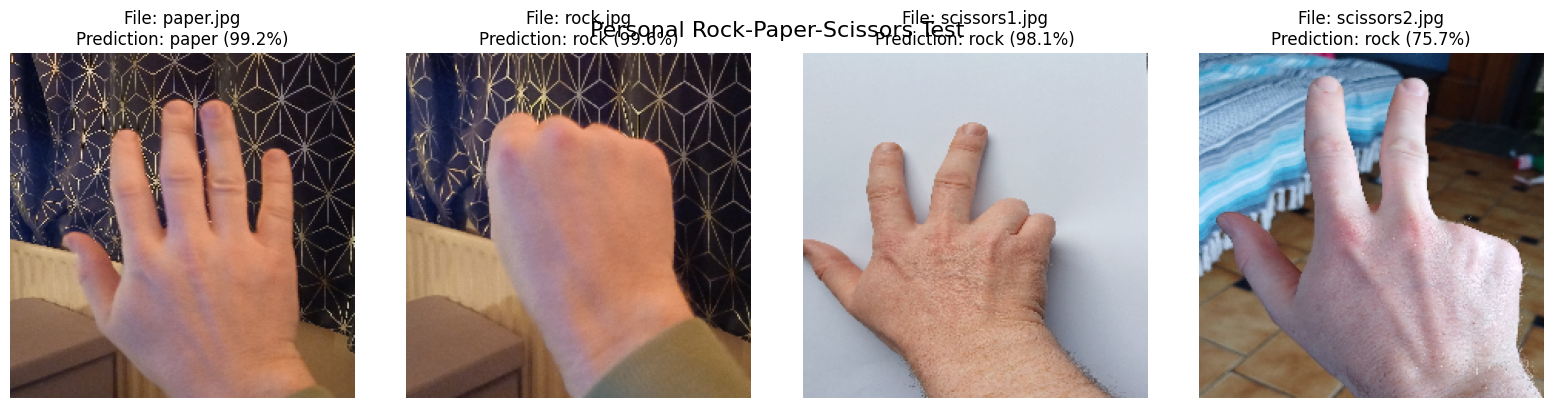


=== Personal Image Test Results ===
Total images tested: 4
Image 1: paper.jpg → Predicted as paper with 99.17% confidence
Image 2: rock.jpg → Predicted as rock with 99.63% confidence
Image 3: scissors1.jpg → Predicted as rock with 98.15% confidence
Image 4: scissors2.jpg → Predicted as rock with 75.73% confidence


In [ ]:
# Load and test personal images
personal_folder = 'personal_dataset'
personal_images, personal_filenames = load_personal_images(personal_folder, IMG_SIZE_VGG)

# Get the best model (fine-tuned VGG16)
best_model = vgg16_finetune_results['model']

# Predict classes
predictions = best_model.predict(personal_images)
predicted_classes = np.argmax(predictions, axis=1)

# Convert class indices to class names
predicted_labels = [class_names[idx] for idx in predicted_classes]

# Calculate grid dimensions based on number of images
n_images = len(personal_images)
n_cols = min(4, n_images)  # At most 4 columns
n_rows = (n_images + n_cols - 1) // n_cols  # Ceiling division

# Display images with predictions
plt.figure(figsize=(4*n_cols, 4*n_rows))
for i, (img, file_name, pred_label) in enumerate(zip(personal_images, personal_filenames, predicted_labels)):
    if i < n_rows * n_cols:  # Ensure we don't exceed the grid
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img)
        confidence = np.max(predictions[i]) * 100
        plt.title(f"File: {file_name}\nPrediction: {pred_label} ({confidence:.1f}%)")
        plt.axis('off')

plt.tight_layout()
plt.suptitle("Personal Rock-Paper-Scissors Test", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Print a summary of results
print("\n=== Personal Image Test Results ===")
print(f"Total images tested: {len(personal_images)}")
for i, (file_name, pred_label) in enumerate(zip(personal_filenames, predicted_labels)):
    confidence = np.max(predictions[i]) * 100
    print(f"Image {i+1}: {file_name} → Predicted as {pred_label} with {confidence:.2f}% confidence")

## **Visualising Preprocessing and Predicting a Single Image**

- A personal image is visualised at three stages: original, resized, and VGG-16 preprocessed  

- The VGG-16 preprocessing includes resizing, RGB conversion, and ImageNet normalisation  

- A single preprocessed image is passed through the model for direct prediction  

- The predicted class and confidence score are printed to verify correct inference  

Image array shape: (224, 224, 3), dtype: float32


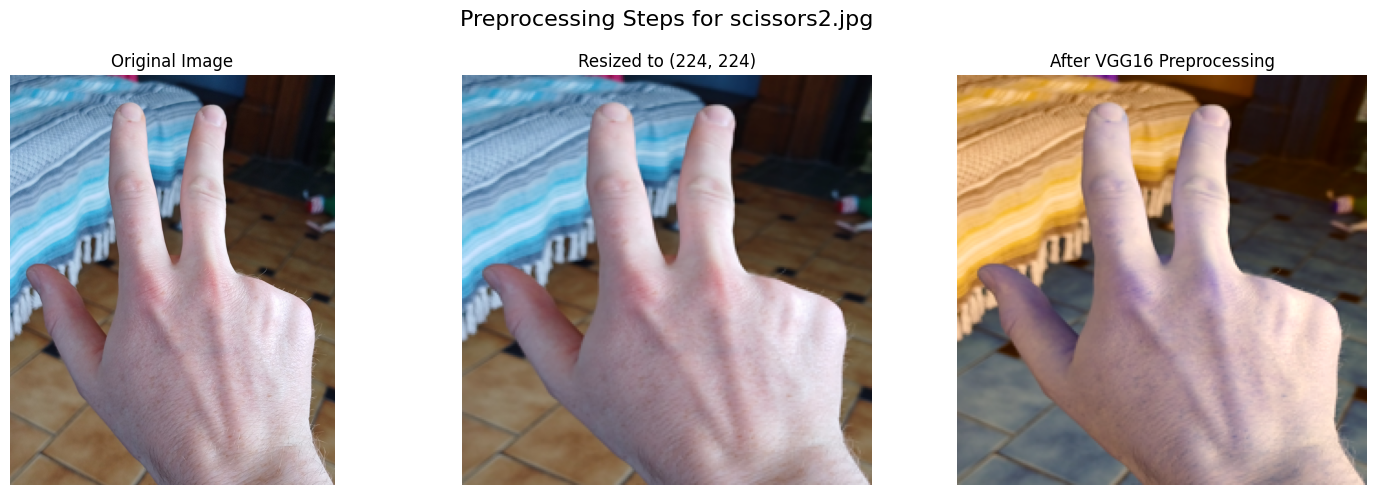

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Prediction: rock with 100.00% confidence


In [ ]:
# Function to visualise the image at different stages
def visualise_preprocessing_steps(image_path, target_size=(224, 224)):
    # Original image
    original_img = Image.open(image_path)
    plt.figure(figsize=(15, 5))
    
    # Plot original
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')
    
    # Resized image and convert to RGB if needed
    resized_img = original_img.resize(target_size)
    if resized_img.mode == 'RGBA':
        print("Converting RGBA image to RGB")
        resized_img = resized_img.convert('RGB')
    
    plt.subplot(1, 3, 2)
    plt.imshow(resized_img)
    plt.title(f"Resized to {target_size}")
    plt.axis('off')
    
    # Preprocessed for VGG16
    img_array = tf.keras.preprocessing.image.img_to_array(resized_img)
    print(f"Image array shape: {img_array.shape}, dtype: {img_array.dtype}")
    img_preprocessed = preprocess_input(img_array.copy())
    
    # For display (convert back from preprocessed)
    # Note: This won't perfectly recover the image due to normalization
    display_img = (img_preprocessed + np.array([123.68, 116.779, 103.939])) / 255.0
    display_img = np.clip(display_img, 0, 1)
    
    plt.subplot(1, 3, 3)
    plt.imshow(display_img)
    plt.title("After VGG16 Preprocessing")
    plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Preprocessing Steps for {os.path.basename(image_path)}", fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    return img_preprocessed

# Check your personal scissors image
scissors_img_path = os.path.join('personal_dataset', 'scissors2.jpg')  # Using the requested image
preprocessed_img = visualise_preprocessing_steps(scissors_img_path)

# Test single image prediction directly
preprocessed_img = np.expand_dims(preprocessed_img, axis=0)  # Add batch dimension
prediction = vgg16_finetune_results['model'].predict(preprocessed_img)
class_idx = np.argmax(prediction[0])
confidence = np.max(prediction[0]) * 100
print(f"Prediction: {class_names[class_idx]} with {confidence:.2f}% confidence")

## **Testing Personal Images with Full Image Preservation**

- A custom preprocessing function resizes and pads each image to 224×224 without cropping  

- All personal images are passed through the fine-tuned VGG-16 model using this method  

- Predictions and confidence scores are displayed in a visual grid  

- A summary table shows classification outcomes for each image  

- Gesture-wise accuracy is calculated by inferring the true class from filenames  

- This approach ensures that model input retains the entire visual context of the original image  

Found 13 images in personal_dataset


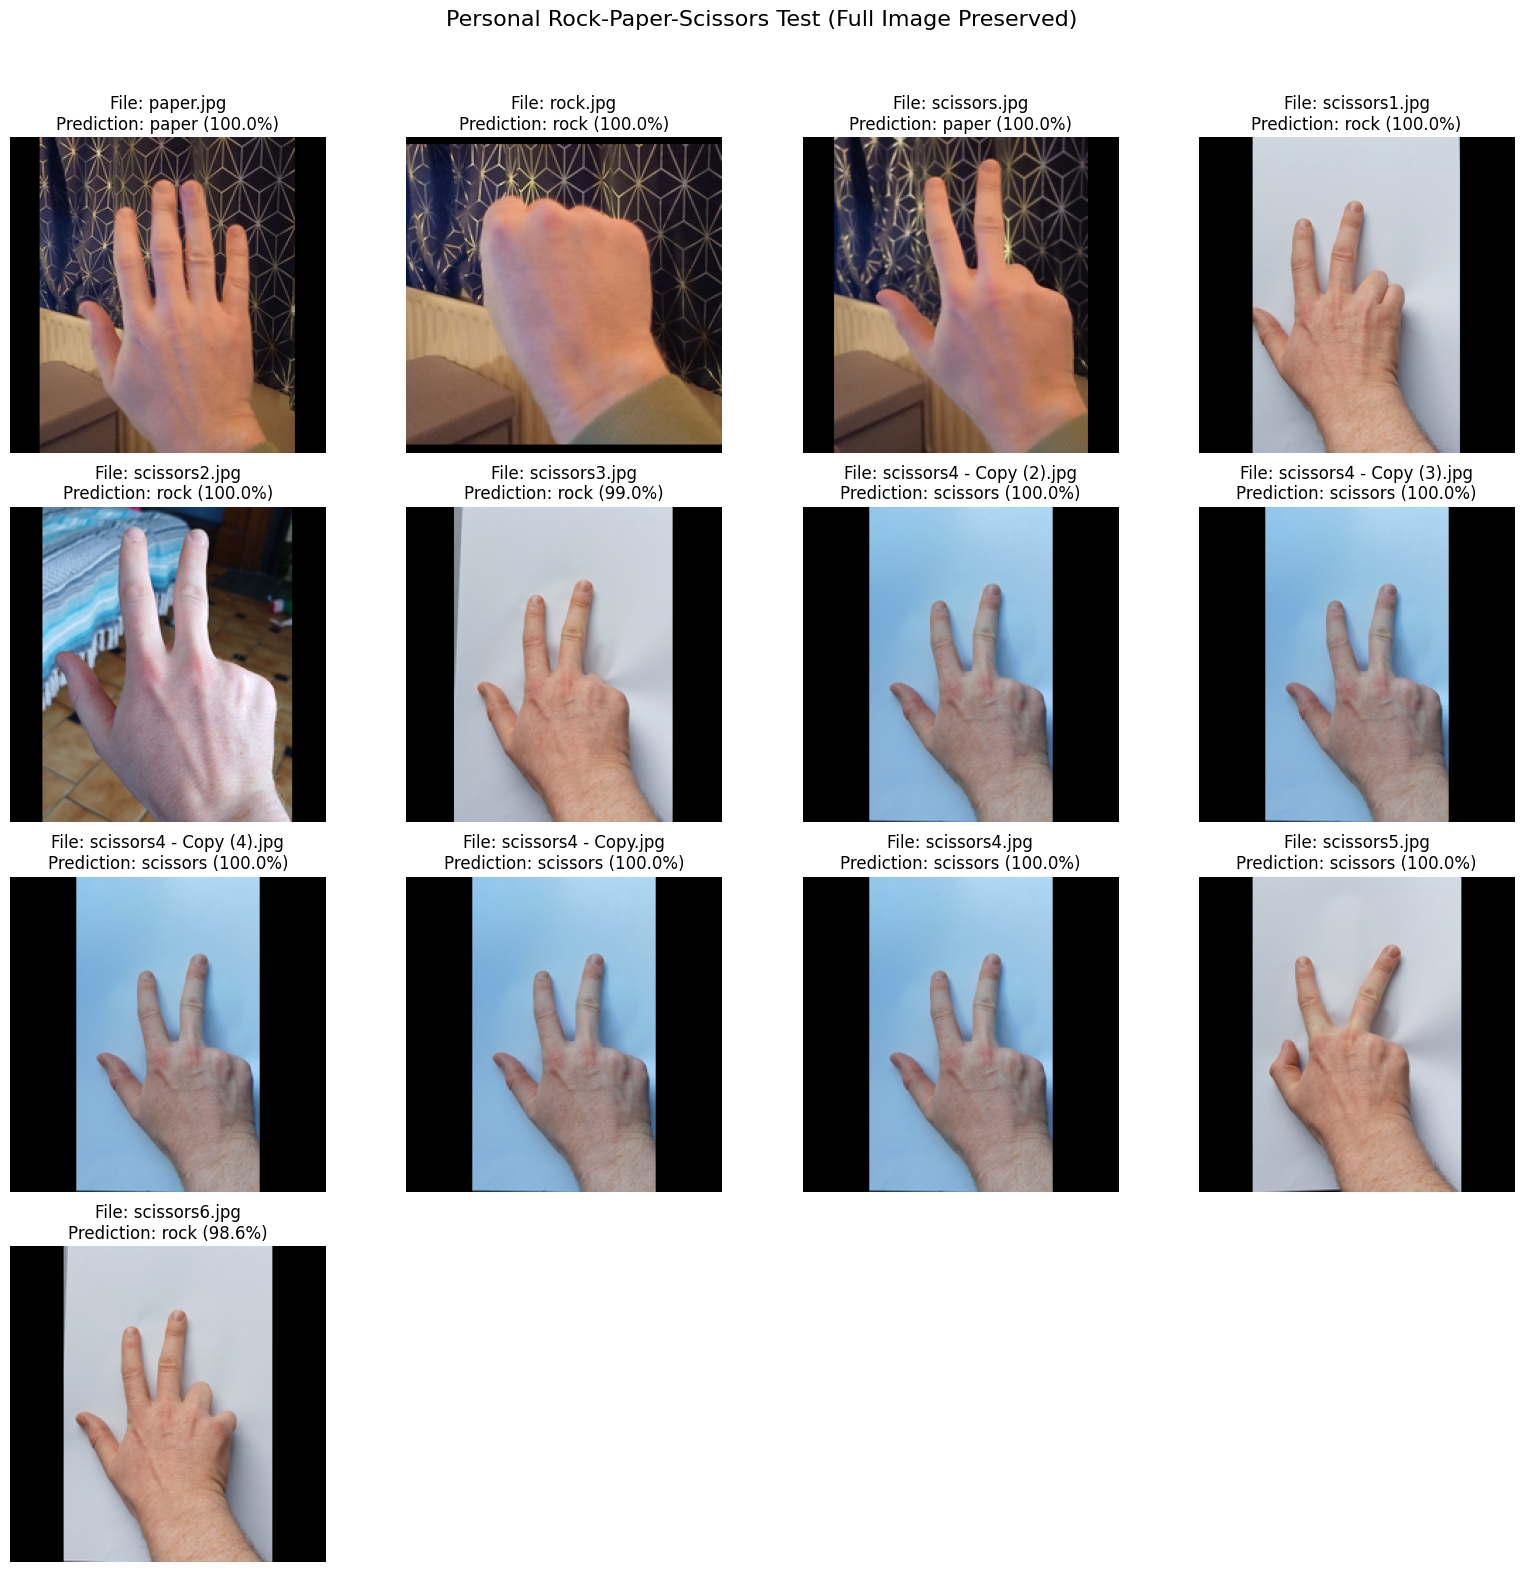


=== Personal Image Test Results (Full Image Preservation) ===
Total images tested: 13
Image 1: paper.jpg → Predicted as paper with 100.00% confidence
Image 2: rock.jpg → Predicted as rock with 100.00% confidence
Image 3: scissors.jpg → Predicted as paper with 100.00% confidence
Image 4: scissors1.jpg → Predicted as rock with 100.00% confidence
Image 5: scissors2.jpg → Predicted as rock with 100.00% confidence
Image 6: scissors3.jpg → Predicted as rock with 98.98% confidence
Image 7: scissors4 - Copy (2).jpg → Predicted as scissors with 100.00% confidence
Image 8: scissors4 - Copy (3).jpg → Predicted as scissors with 100.00% confidence
Image 9: scissors4 - Copy (4).jpg → Predicted as scissors with 100.00% confidence
Image 10: scissors4 - Copy.jpg → Predicted as scissors with 100.00% confidence
Image 11: scissors4.jpg → Predicted as scissors with 100.00% confidence
Image 12: scissors5.jpg → Predicted as scissors with 100.00% confidence
Image 13: scissors6.jpg → Predicted as rock with 98

In [ ]:
def preprocess_preserve_full_image(image_path, target_size=224):
    """
    Preprocess image preserving the ENTIRE image content by resizing
    and padding without cropping anything off.
    """
    # Open image
    img = Image.open(image_path)
    if img.mode == 'RGBA':
        img = img.convert('RGB')
    
    # Get original dimensions
    width, height = img.size
    
    # Calculate resize ratio while ensuring the ENTIRE image fits
    ratio = min(target_size/width, target_size/height)
    
    # Calculate new size that preserves the entire image
    new_width = int(width * ratio)
    new_height = int(height * ratio)
    
    # Resize while preserving aspect ratio without cropping
    resized_img = img.resize((new_width, new_height), Image.LANCZOS)
    
    # Create a black background of target size
    new_img = Image.new("RGB", (target_size, target_size), color=(0, 0, 0))
    
    # Calculate position to paste (center)
    paste_x = (target_size - new_width) // 2
    paste_y = (target_size - new_height) // 2
    
    # Paste the resized image onto the black background
    new_img.paste(resized_img, (paste_x, paste_y))
    
    # Convert to array
    img_array = tf.keras.preprocessing.image.img_to_array(new_img)
    
    # Return both the display version and the preprocessed version
    return img_array, preprocess_input(img_array.copy())

# Process and test all personal images with full image preservation
def test_all_personal_images_preserved(folder_path, model, class_names):
    """
    Test all images in a folder using full image preservation preprocessing
    """
    # List all files in the directory
    files = os.listdir(folder_path)
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"Found {len(image_files)} images in {folder_path}")
    
    # Store results and processed images for display
    results = []
    display_images = []
    
    for file_name in image_files:
        file_path = os.path.join(folder_path, file_name)
        
        # Process with full image preservation
        display_img_array, preprocessed_img = preprocess_preserve_full_image(file_path)
        
        # Add batch dimension for prediction
        input_img = np.expand_dims(preprocessed_img, axis=0)
        
        # Predict
        prediction = model.predict(input_img, verbose=0)
        class_idx = np.argmax(prediction[0])
        confidence = np.max(prediction[0]) * 100
        
        # Save results and display image
        results.append({
            'file_name': file_name,
            'prediction': class_names[class_idx],
            'confidence': confidence
        })
        display_images.append(display_img_array / 255.0)
    
    return results, display_images

# Test all personal images with full image preservation
personal_folder = 'personal_dataset'
all_results, display_images = test_all_personal_images_preserved(
    personal_folder, 
    vgg16_finetune_results['model'],
    class_names
)

# Display results in a grid with full image preservation
n_images = len(all_results)
n_cols = min(4, n_images)
n_rows = (n_images + n_cols - 1) // n_cols

plt.figure(figsize=(4*n_cols, 4*n_rows))
for i, (result, img) in enumerate(zip(all_results, display_images)):
    if i < n_rows * n_cols:
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img)
        plt.title(f"File: {result['file_name']}\nPrediction: {result['prediction']} ({result['confidence']:.1f}%)")
        plt.axis('off')

plt.tight_layout()
plt.suptitle("Personal Rock-Paper-Scissors Test (Full Image Preserved)", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

# Print summary of results
print("\n=== Personal Image Test Results (Full Image Preservation) ===")
print(f"Total images tested: {len(all_results)}")
for i, result in enumerate(all_results):
    print(f"Image {i+1}: {result['file_name']} → Predicted as {result['prediction']} with {result['confidence']:.2f}% confidence")

# Analyze results by gesture type
print("\n=== Analysis by Gesture Type ===")
gesture_results = {
    'rock': {'correct': 0, 'total': 0},
    'paper': {'correct': 0, 'total': 0},
    'scissors': {'correct': 0, 'total': 0}
}

# Count correct predictions by gesture type
# You'll need to manually identify the true gesture for each file
# This is just a template - adjust according to your actual file names
for result in all_results:
    file_name = result['file_name'].lower()
    
    # Try to determine true gesture from filename
    true_gesture = None
    if 'rock' in file_name:
        true_gesture = 'rock'
    elif 'paper' in file_name:
        true_gesture = 'paper'
    elif 'scissors' in file_name:
        true_gesture = 'scissors'
    
    if true_gesture:
        gesture_results[true_gesture]['total'] += 1
        if result['prediction'] == true_gesture:
            gesture_results[true_gesture]['correct'] += 1

# Print accuracy by gesture type
for gesture, counts in gesture_results.items():
    if counts['total'] > 0:
        accuracy = (counts['correct'] / counts['total']) * 100
        print(f"{gesture.capitalize()}: {counts['correct']}/{counts['total']} correct ({accuracy:.1f}%)")

## **Rock-Paper-Scissors Winner Logic**

- A helper function is defined to determine the winner of a rock-paper-scissors game  

- The function compares two predicted gestures and returns the result  

- Follows standard game rules:  
  - Rock beats Scissors  
  - Scissors beats Paper  
  - Paper beats Rock  
- If both gestures are the same, the result is a tie  

In [ ]:
# Function to determine the winner of a rock-paper-scissors game

def determine_winner(gesture1, gesture2):
    """
    Determine the winner of a rock-paper-scissors game based on gestures.
    
    Args:
        gesture1: First gesture (rock, paper, or scissors)
        gesture2: Second gesture (rock, paper, or scissors)
        
    Returns:
        String indicating the winner or tie
    """
    # Game rules:
    # Rock beats scissors
    # Scissors beats paper
    # Paper beats rock
    
    if gesture1 == gesture2:
        return "It's a tie!"
    
    if ((gesture1 == 'rock' and gesture2 == 'scissors') or
        (gesture1 == 'scissors' and gesture2 == 'paper') or
        (gesture1 == 'paper' and gesture2 == 'rock')):
        return "Player 1 wins!"
    else:
        return "Player 2 wins!"

## **Predicting a Rock-Paper-Scissors Game from Two Images**

- A function is defined to predict the outcome of a rock-paper-scissors game using two input images  

- Each image is preprocessed with full-image preservation and passed through the trained model  

- The predicted gesture and confidence score are extracted for both players  

- The winner is determined using the standard game logic  

- The function returns predictions for both players along with the final game result  

In [ ]:
# Function to predict the winner of a rock-paper-scissors game from two images

def predict_rps_game(model, image_path1, image_path2, class_names):
    """
    Predict gestures from two images and determine the winner.
    
    Args:
        model: The trained model to use for prediction
        image_path1: Path to the first player's gesture image
        image_path2: Path to the second player's gesture image
        class_names: List of class names
        
    Returns:
        Dictionary with predictions and game result
    """
    # Process images
    def process_image(image_path, target_size=224):
        # Load and preprocess the image
        display_img_array, preprocessed_img = preprocess_preserve_full_image(image_path, target_size)
        
        # Make prediction
        input_img = np.expand_dims(preprocessed_img, axis=0)
        prediction = model.predict(input_img, verbose=0)
        class_idx = np.argmax(prediction[0])
        confidence = np.max(prediction[0]) * 100
        
        return {
            'file_name': os.path.basename(image_path),
            'gesture': class_names[class_idx],
            'confidence': confidence,
            'display_img': display_img_array / 255.0
        }
    
    # Get predictions for both images
    player1 = process_image(image_path1)
    player2 = process_image(image_path2)
    
    # Determine the winner
    result = determine_winner(player1['gesture'], player2['gesture'])
    
    return {
        'player1': player1,
        'player2': player2,
        'result': result
    }

## **Running Rock-Paper-Scissors Games with Personal Images**

- Three full games are simulated using personal images for rock, paper, and scissors  

- Each image is classified by the fine-tuned VGG-16 model to determine the player’s gesture  

- The game logic determines the winner based on predicted gestures  

- Images, predictions, confidence levels, and outcomes are visually displayed and printed  

- This step demonstrates end-to-end application of the model in a real-world game scenario  


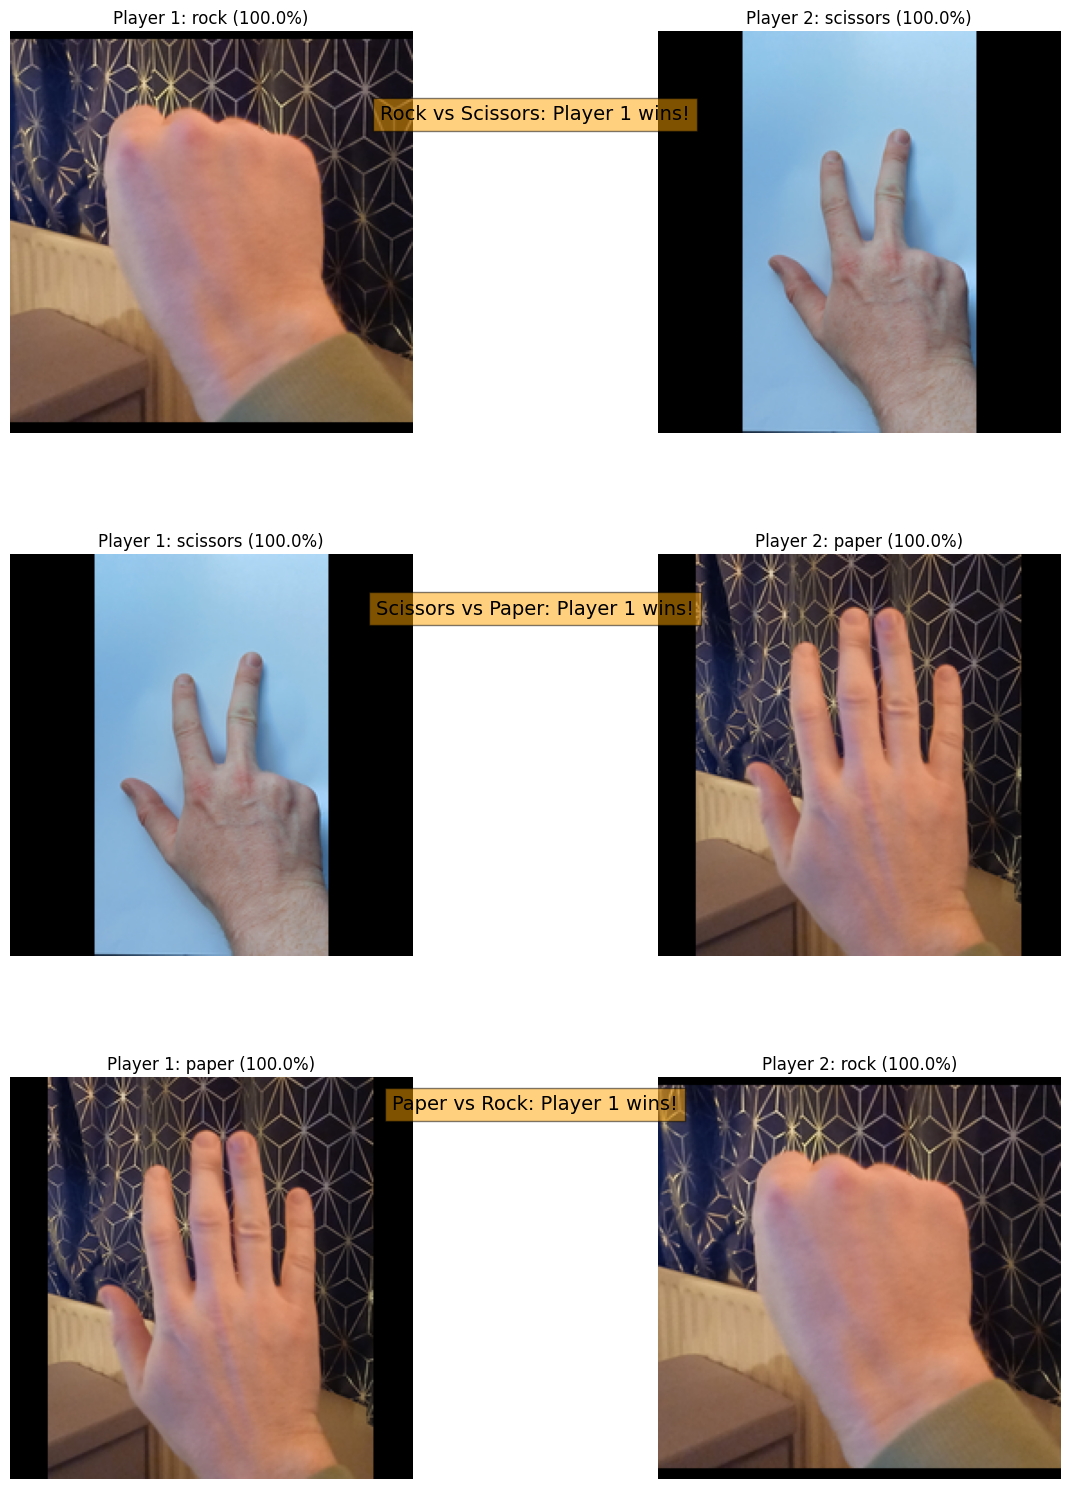


=== Rock-Paper-Scissors Game Results ===

Game 1: Rock vs Scissors
Player 1: rock.jpg → rock (100.0%)
Player 2: scissors4.jpg → scissors (100.0%)
Result: Player 1 wins!

Game 2: Scissors vs Paper
Player 1: scissors4.jpg → scissors (100.0%)
Player 2: paper.jpg → paper (100.0%)
Result: Player 1 wins!

Game 3: Paper vs Rock
Player 1: paper.jpg → paper (100.0%)
Player 2: rock.jpg → rock (100.0%)
Result: Player 1 wins!


In [ ]:
# Output the results of the game

personal_folder = 'personal_dataset'
files = os.listdir(personal_folder)
image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Let's choose a rock and a scissors image
rock_image = None
scissors_image = None
paper_image = None

for file in image_files:
    if 'rock' in file.lower():
        rock_image = os.path.join(personal_folder, file)
    elif 'scissors4' in file.lower():  # Use one of the correctly recognized scissors images
        scissors_image = os.path.join(personal_folder, file)
    elif 'paper' in file.lower():
        paper_image = os.path.join(personal_folder, file)

# Make sure we found the images
if rock_image and scissors_image and paper_image:
    # Use the best model (VGG16)
    best_model = vgg16_finetune_results['model']
    
    # Play three games with different combinations
    games = [
        (rock_image, scissors_image, "Rock vs Scissors"),
        (scissors_image, paper_image, "Scissors vs Paper"),
        (paper_image, rock_image, "Paper vs Rock")
    ]
    
    # Display the games and results
    plt.figure(figsize=(15, 5 * len(games)))
    
    for i, (img1, img2, title) in enumerate(games):
        game_result = predict_rps_game(best_model, img1, img2, class_names)
        
        # Display the images and result
        plt.subplot(len(games), 2, i*2 + 1)
        plt.imshow(game_result['player1']['display_img'])
        plt.title(f"Player 1: {game_result['player1']['gesture']} ({game_result['player1']['confidence']:.1f}%)")
        plt.axis('off')
        
        plt.subplot(len(games), 2, i*2 + 2)
        plt.imshow(game_result['player2']['display_img'])
        plt.title(f"Player 2: {game_result['player2']['gesture']} ({game_result['player2']['confidence']:.1f}%)")
        plt.axis('off')
        
        plt.figtext(0.5, 0.92 - i*0.33, f"{title}: {game_result['result']}", 
                   ha="center", va="center", fontsize=14, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3)
    plt.show()
    
    # Print the results
    print("\n=== Rock-Paper-Scissors Game Results ===")
    for i, (img1, img2, title) in enumerate(games):
        game_result = predict_rps_game(best_model, img1, img2, class_names)
        print(f"\nGame {i+1}: {title}")
        print(f"Player 1: {os.path.basename(img1)} → {game_result['player1']['gesture']} ({game_result['player1']['confidence']:.1f}%)")
        print(f"Player 2: {os.path.basename(img2)} → {game_result['player2']['gesture']} ({game_result['player2']['confidence']:.1f}%)")
        print(f"Result: {game_result['result']}")
else:
    print("Could not find appropriate images. Please specify file paths manually.")
    # If automatic image selection fails, you can manually specify paths:
    # rock_image = os.path.join(personal_folder, "rock.jpg")
    # scissors_image = os.path.join(personal_folder, "scissors4.jpg")
    # paper_image = os.path.join(personal_folder, "paper.jpg")